# Feature Engineering

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
sns.set() # Setting seaborn as default style even if use only matplotlib
pd.set_option('display.max_rows', None)

In [10]:
def target_rel(df, feature, feature_title):
    
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1,2, sharex=False, figsize=(10,5))
    fig.suptitle(f'Arrival Delay by {feature_title}')

    sns.barplot(ax=axes[0], data=df, x=feature, y='arr_delay')
    sns.stripplot(ax=axes[1], data=df,x=feature, y='arr_delay')
    axes[0].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='x', rotation=45)

In [ ]:
# get the cleaned dataset

import pickle

with open(r'data\flight_data.pickle','rb') as flight_data_file:
     df_flights = pickle.load(flight_data_file)

In [ ]:
# get the test features that any engineered features must be linked to

df_test_features = pd.read_csv(r'csvs\test_features.csv', sep=',')

In [ ]:
test_feat = list(df_test_features.columns)

In [ ]:
# select only the test features and the target from the training dataset

df_flights = pd.concat([df_flights[test_feat], df_flights['arr_delay']],axis=1)

In [ ]:
# use this to get year / month / day from fl_date on test set

df_test_features['fl_date_new'] = pd.to_datetime(df_test_features['fl_date'], unit='ms')
df_test_features['year'] = df_test_features['fl_date_new'].dt.year
df_test_features['month'] = df_test_features['fl_date_new'].dt.month
df_test_features['day'] = df_test_features['fl_date_new'].dt.day
df_test_features.tail()

# Round 1

### Mean/Median Monthly Arrival Delay and Arr_Delay

In [ ]:
df_flights['fl_date'] = pd.to_datetime(df_flights['fl_date'])
df_flights['year'] = df_flights['fl_date'].dt.year
df_flights['month'] = df_flights['fl_date'].dt.month
df_flights['day'] = df_flights['fl_date'].dt.day

In [ ]:
## look at correlation between month and arr_delay

mean_arr_delay = df_flights.groupby('month', as_index=False).agg(mean_arr_delay = ('arr_delay','mean')).sort_values(by='mean_arr_delay', ascending=False)
mean_arr_delay.set_index('month',inplace=True)
mean_arr_delay = mean_arr_delay.T
mean_arr_delay

In [ ]:
month_dict = mean_arr_delay.to_dict('records')

In [ ]:
month_dict

In [ ]:
df_flights['mean_arr_delay'] = df_flights['month'].map(month_dict[0])

In [ ]:
df_flights.head()

In [ ]:
df_flights['arr_delay'].corr(df_flights['mean_arr_delay'])

In [ ]:
target_rel(df_flights, feature='mean_arr_delay', feature_title='Mean Monthly Arrival Delay')

In [ ]:
g = sns.scatterplot(data=df_flights, x='mean_arr_delay', y='arr_delay')
g.set_title('Arrival Delay by Mean Flight Number Delay')

In [ ]:
# get median monthly arrival delay

median_arr_delay = df_flights.groupby('month', as_index=False).agg(median_arr_delay = ('arr_delay','median')).sort_values(by='median_arr_delay', ascending=False)
median_arr_delay.set_index('month',inplace=True)
median_arr_delay = median_arr_delay.T
median_arr_delay

In [ ]:
month_dict = median_arr_delay.to_dict('records')

In [ ]:
df_flights['median_arr_delay'] = df_flights['month'].map(month_dict[0])
df_flights.head()

In [ ]:
df_flights['arr_delay'].corr(df_flights['median_arr_delay'])

In [ ]:
target_rel(df_flights, feature='median_arr_delay', feature_title='Median Monthly Arrival Delay')

### Season and Arr_Delay

In [ ]:
## look at relationship between season and arr_delay

season_dict = {
    1:'Winter',
    2:'Winter',
    3:'Spring',
    4:'Spring',
    5:'Spring',
    6:'Summer',
    7:'Summer',
    8:'Summer',
    9:'Fall',
    10:'Fall',
    11:'Fall',
    12:'Winter'}
df_flights["season"] = df_flights["month"].map(season_dict)


In [ ]:
df_flights.head()

In [ ]:
target_rel(df_flights, feature='season', feature_title='Season')

### Day of Week and Arr_Delay

In [ ]:
# see if there's a relationship between day of week and arr_delay

# df_flights['fl_date'] = pd.to_datetime(df_flights['fl_date'])

In [ ]:
df_flights['day_of_week'] = df_flights['fl_date'].dt.day_name()

In [ ]:
df_flights.head()

In [ ]:
target_rel(df_flights, feature='day_of_week', feature_title='Day of Week')

### Weekday/Weekend and Arr_Delay

In [ ]:
df_flights["is_weekend"] = df_flights['fl_date'].dt.dayofweek > 4

In [ ]:
df_flights[['day_of_week','is_weekend']].groupby(['day_of_week','is_weekend']).count()

In [ ]:
target_rel(df_flights, feature='is_weekend', feature_title='Weekday vs. Weekend')

### Holidays and Arr_Delay

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dr = pd.date_range(start='2018-01-01', end='2019-12-31')

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

df_flights['is_holiday'] = df_flights['fl_date'].isin(holidays)
df_flights.head()

In [ ]:
target_rel(df_flights, feature='is_holiday', feature_title='Normal Day vs. Holiday')

### Departure Time of Day and Arr_Delay

In [ ]:
# look at relationship between departure time of day and arr_delay

df_flights['crs_dep_time'] = df_flights['crs_dep_time'].astype(int)

In [ ]:
df_flights['crs_dep_time'] = pd.to_datetime(df_flights['crs_dep_time'], format = '%H%M', errors = 'coerce')
df_flights['crs_dep_time_hour'] = df_flights['crs_dep_time'].dt.hour

In [ ]:
cut_labels_5 = ['early morning', 'late morning', 'midday', 'late afternoon', 'evening']
cut_bins = [1, 5, 10, 15, 20, 24]
df_flights['crs_dep_time_of_day'] = pd.cut(df_flights['crs_dep_time_hour'], bins=cut_bins, labels=cut_labels_5)

In [ ]:
df_flights.head(20)

In [ ]:
target_rel(df_flights, feature='crs_dep_time_of_day', feature_title='Departure Time of Day')

In [ ]:
df_flights.loc[df_flights['crs_dep_time'].isna(), ['crs_dep_time']]

In [ ]:
df_flights.dropna(inplace=True)

In [ ]:
df_flights.loc[df_flights['crs_dep_time'].isna(), ['crs_dep_time']]

### Arrival Time of Day and Arr_Delay

In [ ]:
# look at relationship between arrival time of day and arr_delay

df_flights['crs_arr_time'] = df_flights['crs_arr_time'].astype(int)

In [ ]:
df_flights['crs_arr_time'] = pd.to_datetime(df_flights['crs_arr_time'], format = '%H%M', errors = 'coerce')
df_flights['crs_arr_time_hour'] = df_flights['crs_arr_time'].dt.hour

In [ ]:
cut_labels_5 = ['early morning', 'late morning', 'midday', 'late afternoon', 'evening']
cut_bins = [1, 5, 10, 15, 20, 24]
df_flights['crs_arr_time_of_day'] = pd.cut(df_flights['crs_arr_time_hour'], bins=cut_bins, labels=cut_labels_5)

In [ ]:
df_flights.head(20)

In [ ]:
target_rel(df_flights, feature='crs_arr_time_of_day', feature_title='Arrival Time of Day')

In [ ]:
len(df_flights.loc[df_flights['crs_arr_time'].isna(), ['crs_arr_time']])

In [ ]:
df_flights.dropna(inplace=True)

In [ ]:
df_flights.loc[df_flights['crs_arr_time'].isna(), ['crs_arr_time']]

### Region and Arr_Delay

In [ ]:
# look at relationship between region and arr_delay

In [ ]:
new_origin = df_flights['origin_city_name'].str.split(",", n = 1, expand = True)
new_origin.head()

In [ ]:
new_dest = df_flights['dest_city_name'].str.split(",", n = 1, expand = True)
new_dest.head()

In [ ]:
df_flights['origin_state'] = new_origin[1].str.strip()
df_flights['dest_state'] = new_dest[1].str.strip()
df_flights.head()

In [ ]:
# Add a region feature that groups states into four regions
# Region Dictionary for States *includes DC and Puerto Rico

state_region = {
    'WA': 'West',
    'OR': 'West',
    'CA': 'West',
    'AK': 'West',
    'HI': 'West',
    'ID': 'West',
    'MT': 'West',
    'WY': 'West',
    'NV': 'West',
    'UT': 'West',
    'CO': 'West',
    'AZ': 'West',
    'NM': 'West',
    'ND': 'Midwest',
    'SD': 'Midwest',
    'MN': 'Midwest',
    'NE': 'Midwest',
    'KS': 'Midwest',
    'IA': 'Midwest',
    'MO': 'Midwest',
    'WI': 'Midwest',
    'IL': 'Midwest',
    'MI': 'Midwest',
    'IN': 'Midwest',
    'OH': 'Midwest',
    'VT': 'Northeast',
    'ME': 'Northeast',
    'NH': 'Northeast',
    'MA': 'Northeast',
    'NY': 'Northeast',
    'PA': 'Northeast',
    'RI': 'Northeast',
    'CT': 'Northeast',
    'NJ': 'Northeast',
    'DE': 'South',
    'MD': 'South',
    'WV': 'South',
    'DC': 'South',
    'VA': 'South',
    'KY': 'South',
    'NC': 'South',
    'OK': 'South',
    'TX': 'South',
    'AR': 'South',
    'LA': 'South',
    'MS': 'South',
    'AL': 'South',
    'TN': 'South',
    'SC': 'South',
    'GA': 'South',
    'FL': 'South',
    'PR': 'Other',
    'VI': 'Other',
    'TT': 'Other'
}
len(state_region)

In [ ]:
df_flights["origin_region"] = df_flights["origin_state"].map(state_region)

In [ ]:
df_flights["dest_region"] = df_flights["dest_state"].map(state_region)

In [ ]:
df_flights.head()

In [ ]:
df_flights['origin_region'].value_counts()

In [ ]:
target_rel(df_flights, feature='origin_region', feature_title='Flight Origin')

In [ ]:
target_rel(df_flights, feature='dest_region', feature_title='Destination Region')

### Flight Type and Arr_Delay

In [ ]:
# look at relationship between flight type and arr_delay

df_flights['haul'] = pd.cut(df_flights['distance'], bins = [0,800,2200,5000],labels=['short','medium','long'])
df_flights.head()

In [ ]:
target_rel(df_flights, feature='haul', feature_title='Flight Type')

In [ ]:
# drop unneeded features

# df_flights = df_flights.drop(columns=['fl_date','dup','flights','mkt_carrier','mkt_carrier_fl_num','tail_num','op_carrier_fl_num','origin_airport_id','origin','origin_city_name','dest_airport_id','dest','dest_city_name','crs_dep_time','crs_arr_time'])

In [ ]:
# make a pickle of the feature engineered data
import pickle

#Do Some Feature Engineering
feature_engineered_data = df_flights

#Dump it(save it in binary format)
with open(r'..\data\flight_data_engineered.pickle','wb') as flight_data_file:
     pickle.dump(feature_engineered_data, flight_data_file)

# Round 2

### Origin Airport Mean/Median Arrival Delay and Arr_Delay

In [ ]:
# get the cleaned dataset

import pickle

with open(r'..\data\flight_data_engineered.pickle','rb') as flight_data_file:
     df_flights = pickle.load(flight_data_file)

In [ ]:
filter_df = df_flights[['origin_airport_id','arr_delay','origin_city_name']]
mean_airport_delay = filter_df.groupby('origin_airport_id', as_index=False).agg(mean_airport_delay = ('arr_delay','mean')).sort_values(by='mean_airport_delay', ascending=False)
mean_airport_delay.set_index('origin_airport_id',inplace=True)
mean_airport_delay = mean_airport_delay.T
mean_airport_delay.head()

In [ ]:
airport_dict = mean_airport_delay.to_dict('records')

In [ ]:
airport_dict

In [ ]:
df_flights['mean_origin_airport_delay'] = df_flights['origin_airport_id'].map(airport_dict[0])

In [ ]:
target_rel(df_flights, feature='mean_origin_airport_delay', feature_title='Mean Origin Airport Arrival Delay')

In [ ]:
to_plot = df_flights[(df_flights['arr_delay']>1)&(df_flights['mean_origin_airport_delay']>1)]
to_plot = np.log(to_plot[['arr_delay','mean_origin_airport_delay']])

g = sns.scatterplot(data=to_plot, x='mean_origin_airport_delay', y='arr_delay')
g.set_title('Arrival Delay by Mean Origin Airport Arrival Delay')
to_plot.head()

In [ ]:
df_flights['arr_delay'].corr(df_flights['mean_origin_airport_delay'])

In [ ]:
cut_labels = ['fast','medium-fast','medium-slow','slow']
df_flights['origin_airport_mean_speed'] = pd.qcut(df_flights['mean_origin_airport_delay'], 4, labels=cut_labels)

In [ ]:
df_flights.head()

In [ ]:
target_rel(df_flights, feature='origin_airport_mean_speed', feature_title='Origin Airport Speed (Mean)')

In [ ]:
filter_df = df_flights[['origin_airport_id','arr_delay','origin_city_name']]
median_airport_delay = filter_df.groupby('origin_airport_id', as_index=False).agg(median_airport_delay = ('arr_delay','median')).sort_values(by='median_airport_delay', ascending=False)
median_airport_delay.set_index('origin_airport_id',inplace=True)
median_airport_delay = median_airport_delay.T
median_airport_delay.head()

In [ ]:
airport_dict = median_airport_delay.to_dict('records')

In [ ]:
airport_dict

In [ ]:
df_flights['median_origin_airport_delay'] = df_flights['origin_airport_id'].map(airport_dict[0])

In [ ]:
df_flights['median_origin_airport_delay'].describe()

In [ ]:
target_rel(df_flights, feature='median_origin_airport_delay', feature_title='Median Origin Airport Arrival Delay')

In [ ]:
g = sns.scatterplot(data=df_flights, x='median_origin_airport_delay', y='arr_delay')
g.set_title('Arrival Delay by Median Origin Airport Arrival Delay')

In [ ]:
df_flights['arr_delay'].corr(df_flights['median_origin_airport_delay'])

In [ ]:
cut_labels = ['fast','medium-fast','medium-slow','slow']
df_flights['origin_airport_median_speed'] = pd.qcut(df_flights['median_origin_airport_delay'], 4, labels=cut_labels)

In [ ]:
target_rel(df_flights, feature='origin_airport_median_speed', feature_title='Origin Airport Speed (Median)')

In [ ]:
df_flights['median_origin_airport_delay'].describe()

In [ ]:
df_flights[['median_origin_airport_delay','origin_airport_median_speed','mean_origin_airport_delay','origin_airport_mean_speed','origin_city_name']].head(50)

In [ ]:
df_flights.head()

In [ ]:
df_flights.columns

### Destination Airport Mean Arrival Delay and Arr_Delay

In [ ]:
filter_df = df_flights[['dest_airport_id','arr_delay','origin_city_name']]
mean_airport_delay = filter_df.groupby('dest_airport_id', as_index=False).agg(mean_airport_delay = ('arr_delay','mean')).sort_values(by='mean_airport_delay', ascending=False)
mean_airport_delay.set_index('dest_airport_id',inplace=True)
mean_airport_delay = mean_airport_delay.T
mean_airport_delay.head()

In [ ]:
airport_dict = mean_airport_delay.to_dict('records')

In [ ]:
airport_dict

In [ ]:
df_flights['mean_dest_airport_delay'] = df_flights['dest_airport_id'].map(airport_dict[0])

In [ ]:
target_rel(df_flights, feature='mean_dest_airport_delay', feature_title='Mean Destination Airport Arrival Delay')

In [ ]:
g = sns.scatterplot(data=df_flights, x='mean_dest_airport_delay', y='arr_delay')
g.set_title('Arrival Delay by Mean Destination Airport Arrival Delay')

In [ ]:
df_flights['arr_delay'].corr(df_flights['mean_dest_airport_delay'])

In [ ]:
cut_labels = ['fast','medium-fast','medium-slow','slow']
df_flights['dest_airport_mean_speed'] = pd.qcut(df_flights['mean_dest_airport_delay'], 4, labels=cut_labels)

In [ ]:
df_flights.head()

In [ ]:
target_rel(df_flights, feature='dest_airport_mean_speed', feature_title='Destination Airport Speed (Mean)')

In [ ]:
df_flights[['dest_city_name','dest_airport_mean_speed','mean_dest_airport_delay']].head(20)

In [ ]:
df_flights.columns

In [ ]:
compare = df_flights[df_flights['mkt_unique_carrier']==df_flights['op_unique_carrier']]

In [ ]:
compare.shape

In [ ]:
# mkt_unique_carrier and op_unique_carrier are often the same value, so drop one to reduce noise

In [ ]:
df_flights[['mkt_unique_carrier','op_unique_carrier']].head(10)

In [ ]:
df_flights.columns

In [ ]:
# drop features

df_flights = df_flights.drop(columns=[
    'fl_date',
    'mkt_unique_carrier',
    'branded_code_share',
    'mkt_carrier',
    'mkt_carrier_fl_num',
    'tail_num',
    'op_carrier_fl_num',
    'origin_airport_id',
    'origin',
    'origin_city_name',
    'dest_airport_id',
    'dest',
    'dest_city_name',
    'crs_dep_time',
    'crs_arr_time',
    'dup',
    'flights',
    'distance',
    'year',
    'month',
    'day',
    'median_arr_delay',
    'crs_dep_time_hour',
    'crs_arr_time_hour',
    'origin_state', 
    'dest_state',
    'origin_airport_mean_speed',
    'median_origin_airport_delay',
    'origin_airport_median_speed',
    'dest_airport_mean_speed'
    ])

In [ ]:
df_flights.shape

In [ ]:
# make a pickle of the feature engineered data
import pickle

#Do Some Feature Engineering
feature_engineered_data2 = df_flights

#Dump it(save it in binary format)
with open(r'..\data\flight_data_engineered2.pickle','wb') as flight_data_file:
     pickle.dump(feature_engineered_data2, flight_data_file)

# Round 3

### Flight Number and Arr_Delay

In [ ]:
# get the cleaned dataset

import pickle

with open(r'data\flight_data.pickle','rb') as flight_data_file:
     df_flights = pickle.load(flight_data_file)

In [ ]:
df_flights.head()

In [ ]:
df_flights.shape

In [ ]:
# are the same flight numbers used repeatedly for the same routes? Are the same flights consistently delayed?

# maybe try getting the average delay per carrier flight number using a larger random sample of the data?

In [ ]:
filter_df = df_flights[['fl_date','op_unique_carrier','mkt_unique_carrier','op_carrier_fl_num','mkt_carrier_fl_num','crs_dep_time','arr_delay','origin_city_name','dest_city_name']].sort_values(['op_carrier_fl_num','op_unique_carrier'])
filter_df.head(10)

In [ ]:
df_flights['carrier_fl_num'] =  df_flights['op_unique_carrier'] + df_flights['op_carrier_fl_num'].astype(str)

In [ ]:
df_flights['carrier_fl_num'].value_counts()

In [ ]:
# Carriers sometimes re-use flight numbers for different routes. Sometimes it seems like it depends on time of day (e.g. certain flight number used for certain route in the morning, and different route in the afternoon)

In [ ]:
df_flights['crs_dep_time'] = pd.to_datetime(df_flights['crs_dep_time'], format = '%H%M', errors = 'coerce')

In [ ]:
df_flights['crs_dep_time_hour'] = df_flights['crs_dep_time'].dt.hour

In [ ]:
df_flights.shape

In [ ]:
cut_labels_5 = ['early morning', 'late morning', 'midday', 'late afternoon', 'evening']
cut_bins = [1, 5, 10, 15, 20, 24]
df_flights['crs_dep_time_of_day'] = pd.cut(df_flights['crs_dep_time_hour'], bins=cut_bins, labels=cut_labels_5)

In [ ]:
df_flights.shape

In [ ]:
df_filter = df_flights[['carrier_fl_num','crs_dep_time_of_day','arr_delay']]
group = df_filter.groupby(['carrier_fl_num','crs_dep_time_of_day']).mean('arr_delay')
group.head()

In [ ]:
df_flights['carrier_fl_num_TOD'] = df_flights['carrier_fl_num'] + '-' + df_flights['crs_dep_time_of_day'].astype(str)

In [ ]:
df_flights.head()

In [ ]:
filter_df = df_flights[['carrier_fl_num_TOD','arr_delay']]
filter_df.head()

In [ ]:
# df.groupby([col1, col2]).mean()
# df[[col1, col2, col3]].groupby([col1, col2]).mean()

In [ ]:
mean_flight_num_delay = filter_df.groupby('carrier_fl_num_TOD').agg(mean_arr_delay = ('arr_delay','mean')).sort_values(by='carrier_fl_num_TOD')

In [ ]:
mean_flight_num_delay.head()

In [ ]:
mean_flight_num_delay = mean_flight_num_delay.T

In [ ]:
mean_flight_num_delay.head()

In [ ]:
flight_dict = mean_flight_num_delay.to_dict('records')

In [ ]:
flight_dict

In [ ]:
df_flights['mean_flight_num_delay'] = df_flights['carrier_fl_num_TOD'].map(flight_dict[0])

In [ ]:
df_flights.head()

In [ ]:
target_rel(df_flights, feature='mean_flight_num_delay', feature_title='Mean Flight Number Delay')

In [ ]:
g = sns.scatterplot(data=df_flights, x='mean_flight_num_delay', y='arr_delay')
g.set_title('Arrival Delay by Mean Flight Number Delay')

In [ ]:
df_flights['mean_flight_num_delay'].corr(df_flights['arr_delay'])

In [ ]:
len(df_flights[df_flights['mean_flight_num_delay']==df_flights['arr_delay']])

In [ ]:
len(df_flights[df_flights['mean_flight_num_delay']==1])

In [ ]:
unique_flights = df_flights['carrier_fl_num_TOD'].nunique()
unique_flights

In [ ]:
one_flight_only = sum(df_flights['carrier_fl_num_TOD'].value_counts()==1)
one_flight_only

In [ ]:
percent_one_flight_only = 100*(one_flight_only/unique_flights)
percent_one_flight_only

In [ ]:
df_flights['arr_delay'].describe()

In [ ]:
# drop features

df_flights = df_flights[['mean_flight_num_delay','arr_delay']]

In [ ]:
df_flights.head(20)

In [ ]:
df_flights.shape

In [ ]:
# make a pickle of the feature engineered data
import pickle

#Do Some Feature Engineering
feature_engineered_data3 = df_flights

#Dump it(save it in binary format)
with open(r'..\data\flight_data_engineered3.pickle','wb') as flight_data_file:
     pickle.dump(feature_engineered_data3, flight_data_file)

# Round 4

In [ ]:
# pull more data to get better information about mean delay by flight number by reducing the percentage of flights for which we have only one data point

In [ ]:
# import os
# os.chdir('..')

In [ ]:
from src.modules import connect_lhl, test_models

In [ ]:
conn = connect_lhl.lhl_delay_data('lhl-data-bootcamp.crzjul5qln0e.ca-central-1.rds.amazonaws.com','mid_term_project','lhl_student','lhl_student', 0)
conn.connection()
df_flights = conn.sample_table('flights','500000')

In [ ]:
df_flights.head()

In [ ]:
df_flights.info()

In [ ]:
# make a pickle of the new sample data
import pickle

flights_random_sample_500K = df_flights

with open(r'data\flights_random_sample_500K.pickle','wb') as flight_data_file:
     pickle.dump(flights_random_sample_500K, flight_data_file)

In [ ]:
100*(df_flights.isnull().sum()/len(df_flights))

In [ ]:
# drop features with more than 80% missing values

df_flights = df_flights.dropna(thresh=df_flights.shape[0]*0.8,axis=1)

In [ ]:
# because remaining features with missing values make up such a small proportino of the data, drop observations with missing values

df_flights = df_flights.dropna()

In [ ]:
sum(df_flights.isnull().sum())

In [ ]:
df_flights.shape

In [ ]:
# make a pickle of the cleaned data
import pickle

flights_random_sample_500K = df_flights

with open(r'data\flight_data_500K.pickle','wb') as flight_data_file:
     pickle.dump(flights_random_sample_500K, flight_data_file)

In [ ]:
df_flights['carrier_fl_num'] =  df_flights['op_unique_carrier'] + df_flights['op_carrier_fl_num'].astype(str)

In [ ]:
df_flights['crs_dep_time'] = pd.to_datetime(df_flights['crs_dep_time'], format = '%H%M', errors = 'coerce')

In [ ]:
df_flights['crs_dep_time_hour'] = df_flights['crs_dep_time'].dt.hour

In [ ]:
cut_labels_5 = ['early morning', 'late morning', 'midday', 'late afternoon', 'evening']
cut_bins = [1, 5, 10, 15, 20, 24]
df_flights['crs_dep_time_of_day'] = pd.cut(df_flights['crs_dep_time_hour'], bins=cut_bins, labels=cut_labels_5)

In [ ]:
df_flights['carrier_fl_num_TOD'] = df_flights['carrier_fl_num'] + '-' + df_flights['crs_dep_time_of_day'].astype(str)

In [ ]:
df_flights.head()

In [ ]:
filter_df = df_flights[['carrier_fl_num_TOD','arr_delay']]
filter_df.head()

In [ ]:
mean_flight_num_delay = filter_df.groupby('carrier_fl_num_TOD').agg(mean_arr_delay = ('arr_delay','mean')).sort_values(by='carrier_fl_num_TOD')

In [ ]:
mean_flight_num_delay.head()

In [ ]:
mean_flight_num_delay = mean_flight_num_delay.T

In [ ]:
mean_flight_num_delay.head()

In [ ]:
flight_dict = mean_flight_num_delay.to_dict('records')

In [ ]:
flight_dict

In [ ]:
df_flights['mean_flight_num_delay'] = df_flights['carrier_fl_num_TOD'].map(flight_dict[0])

In [ ]:
df_flights.head()

In [ ]:
target_rel(df_flights, feature='mean_flight_num_delay', feature_title='Mean Flight Number Delay')

In [ ]:
g = sns.scatterplot(data=df_flights, x='mean_flight_num_delay', y='arr_delay')
g.set_title('Arrival Delay by Mean Flight Number Delay')

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data, target, seed=123)

In [ ]:
df_flights['mean_flight_num_delay'].corr(df_flights['arr_delay'])

In [ ]:
len(df_flights[df_flights['mean_flight_num_delay']==df_flights['arr_delay']])

In [ ]:
len(df_flights[df_flights['mean_flight_num_delay']==1])

In [ ]:
unique_flights = df_flights['carrier_fl_num_TOD'].nunique()
unique_flights

In [ ]:
one_flight_only = sum(df_flights['carrier_fl_num_TOD'].value_counts()==1)
one_flight_only

In [ ]:
percent_one_flight_only = 100*(one_flight_only/unique_flights)
percent_one_flight_only

In [ ]:
df_flights['arr_delay'].describe()

In [ ]:
# drop features

df_flights = df_flights[['mean_flight_num_delay','arr_delay']]

In [ ]:
df_flights.head(20)

In [ ]:
df_flights.shape

In [ ]:
# make a pickle of the feature engineered data
import pickle

feature_engineered_data4 = df_flights

with open(r'data\flight_data_engineered4.pickle','wb') as flight_data_file:
     pickle.dump(feature_engineered_data4, flight_data_file)

# Round 5

In [ ]:
# split training set and test set before getting mean arrival delay by carrier+fl_num+TOD, map those results to the training set AND FILL NA using KNN, split carrier+fl_num+TOD back up again

In [2]:
# get the cleaned dataset

import pickle

with open(r'..\data\flight_data.pickle','rb') as flight_data_file:
     df_flights = pickle.load(flight_data_file)

In [3]:
X = df_flights.drop(columns='arr_delay')
y = df_flights['arr_delay']

In [4]:
X.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'cancelled', 'diverted', 'dup',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance'],
      dtype='object')

In [5]:
X.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,crs_arr_time,arr_time,cancelled,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance
0,2018-01-01,WN,WN,WN,5431,WN,N291WN,5431,12889,LAS,...,2350,9.0,0,0,N,140,124.0,112.0,1,986
1,2018-01-01,WN,WN,WN,989,WN,N287WN,989,12889,LAS,...,155,241.0,0,0,N,150,161.0,142.0,1,1099
2,2018-01-01,WN,WN,WN,1664,WN,N751SW,1664,12889,LAS,...,1120,1111.0,0,0,N,150,145.0,132.0,1,1099
3,2018-01-01,WN,WN,WN,1106,WN,N704SW,1106,12889,LAS,...,830,827.0,0,0,N,55,50.0,34.0,1,197
4,2018-01-01,WN,WN,WN,1559,WN,N423WN,1559,12889,LAS,...,1835,1912.0,0,0,N,55,51.0,34.0,1,197


In [6]:
y.head()

0    19.0
1    46.0
2    -9.0
3    -3.0
4    37.0
Name: arr_delay, dtype: float64

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(74267, 31)
(24756, 31)
(74267,)
(24756,)


## Add Feature to Training Set

In [11]:
df_flights_train = pd.concat([X_train, y_train], axis=1)

In [12]:
df_flights_train = df_flights_train.reset_index(drop=True)
df_flights_train.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,arr_time,cancelled,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,arr_delay
0,2018-02-02,WN,WN,WN,182,WN,N8557Q,182,10397,ATL,...,1031.0,0,0,N,125,108.0,91.0,1,666,-14.0
1,2019-07-30,DL,DL_CODESHARE,DL,4247,OO,N460SW,4247,14869,SLC,...,1754.0,0,0,N,60,50.0,30.0,1,175,-11.0
2,2018-04-30,DL,DL_CODESHARE,DL,4701,OO,N878AS,4701,12278,ICT,...,1417.0,0,0,N,112,98.0,81.0,1,545,-5.0
3,2019-04-15,AA,AA_CODESHARE,AA,4966,PT,N620AE,4966,14100,PHL,...,2222.0,0,0,N,47,41.0,17.0,1,55,-11.0
4,2019-09-12,WN,WN,WN,4292,WN,N7719A,4292,11292,DEN,...,1959.0,0,0,N,120,102.0,87.0,1,602,-6.0


In [13]:
df_flights_train['crs_dep_time'] = pd.to_datetime(df_flights_train['crs_dep_time'], format = '%H%M', errors = 'coerce')

In [14]:
df_flights_train[df_flights_train['crs_dep_time'].isnull()]['crs_dep_time']

4895    NaT
10588   NaT
12314   NaT
18881   NaT
22268   NaT
26293   NaT
38058   NaT
40328   NaT
44936   NaT
56819   NaT
71654   NaT
73900   NaT
Name: crs_dep_time, dtype: datetime64[ns]

In [15]:
df_flights_train = df_flights_train[(df_flights_train['crs_dep_time'].isnull()==False)]

In [16]:
df_flights_train.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,arr_time,cancelled,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,arr_delay
0,2018-02-02,WN,WN,WN,182,WN,N8557Q,182,10397,ATL,...,1031.0,0,0,N,125,108.0,91.0,1,666,-14.0
1,2019-07-30,DL,DL_CODESHARE,DL,4247,OO,N460SW,4247,14869,SLC,...,1754.0,0,0,N,60,50.0,30.0,1,175,-11.0
2,2018-04-30,DL,DL_CODESHARE,DL,4701,OO,N878AS,4701,12278,ICT,...,1417.0,0,0,N,112,98.0,81.0,1,545,-5.0
3,2019-04-15,AA,AA_CODESHARE,AA,4966,PT,N620AE,4966,14100,PHL,...,2222.0,0,0,N,47,41.0,17.0,1,55,-11.0
4,2019-09-12,WN,WN,WN,4292,WN,N7719A,4292,11292,DEN,...,1959.0,0,0,N,120,102.0,87.0,1,602,-6.0


In [18]:
df_flights_train['crs_dep_time_hour'] = df_flights_train['crs_dep_time'].dt.hour

In [19]:
cut_labels_5 = ['early morning', 'late morning', 'midday', 'late afternoon', 'evening']
cut_bins = [1, 5, 10, 15, 20, 24]
df_flights_train['crs_dep_time_of_day'] = pd.cut(df_flights_train['crs_dep_time_hour'], bins=cut_bins, labels=cut_labels_5)

In [20]:
# build dict1: carrier+fl_num+TOD+origin+dest

filter_df = df_flights_train[['op_unique_carrier','op_carrier_fl_num','crs_dep_time_of_day','origin_city_name','dest_city_name','arr_delay']]
mean_arr_delay_1 = filter_df.groupby(['op_unique_carrier','op_carrier_fl_num','crs_dep_time_of_day','origin_city_name','dest_city_name'],observed=True).agg(mean_arr_delay=('arr_delay', 'mean'), samples=('arr_delay', 'count'))

# drop all elements in dict1 that don't have at least 5 samples

mean_arr_delay_1 = mean_arr_delay_1[mean_arr_delay_1['samples']>5]
mean_arr_delay_1 = mean_arr_delay_1.reset_index()
mean_arr_delay_1.head()

# build dict

mean_arr_delay_1['key'] = mean_arr_delay_1['op_unique_carrier']+mean_arr_delay_1['op_carrier_fl_num'].astype(str)+mean_arr_delay_1['crs_dep_time_of_day'].astype(str)+mean_arr_delay_1['origin_city_name']+mean_arr_delay_1['dest_city_name']
mean_arr_delay_1 = mean_arr_delay_1[['key','mean_arr_delay']]
mean_arr_delay_1.set_index('key',inplace=True)
mean_arr_delay_1 = mean_arr_delay_1.T
dict1 = mean_arr_delay_1.to_dict('records')
dict1

[{'9E5027late morningCincinnati, OHDetroit, MI': -10.833333333333334,
  'AA31late morningLos Angeles, CAHonolulu, HI': -14.666666666666666,
  'AA34late morningDallas/Fort Worth, TXNewark, NJ': 16.0,
  'AA34middayNewark, NJDallas/Fort Worth, TX': -1.1666666666666667,
  'AA58middayKona, HILos Angeles, CA': -12.833333333333334,
  'AA163late morningLos Angeles, CAWashington, DC': -4.571428571428571,
  'AA163late afternoonWashington, DCLos Angeles, CA': -9.5,
  'AA164late morningSan Francisco, CANew York, NY': -0.3333333333333333,
  'AA168middayLas Vegas, NVChicago, IL': 4.0,
  'AA201late morningSanta Ana, CAPhoenix, AZ': -13.0,
  'AA205middayLos Angeles, CAKahului, HI': 38.5,
  'AA243middayNew York, NYMiami, FL': -9.666666666666666,
  'AA254middayKahului, HILos Angeles, CA': -10.166666666666666,
  'AA315middayDallas/Fort Worth, TXDetroit, MI': 17.0,
  'AA315late afternoonDetroit, MIDallas/Fort Worth, TX': 11.857142857142858,
  'AA395late morningChicago, ILSan Juan, PR': -11.0,
  'AA407midd

In [21]:
# build dict2: TOD+origin+dest

filter_df = df_flights_train[['crs_dep_time_of_day','origin_city_name','dest_city_name','arr_delay']]
mean_arr_delay_2 = filter_df.groupby(['crs_dep_time_of_day','origin_city_name','dest_city_name'],observed=True).agg(mean_arr_delay=('arr_delay', 'mean'), samples=('arr_delay', 'count'))

# drop all elements in dict2 that don't have at least 5 samples

mean_arr_delay_2 = mean_arr_delay_2[mean_arr_delay_2['samples']>5]
mean_arr_delay_2 = mean_arr_delay_2.reset_index()
mean_arr_delay_2.head()

# build dict2

mean_arr_delay_2['key'] = mean_arr_delay_2['crs_dep_time_of_day'].astype(str)+mean_arr_delay_2['origin_city_name']+mean_arr_delay_2['dest_city_name']
mean_arr_delay_2 = mean_arr_delay_2[['key','mean_arr_delay']]
mean_arr_delay_2.set_index('key',inplace=True)
mean_arr_delay_2 = mean_arr_delay_2.T
dict2 = mean_arr_delay_2.to_dict('records')
dict2

[{'early morningAnchorage, AKSeattle, WA': -7.4,
  'early morningAustin, TXDallas/Fort Worth, TX': -9.714285714285714,
  'early morningBoston, MAChicago, IL': -0.42857142857142855,
  'early morningBoston, MAMiami, FL': -9.666666666666666,
  'early morningCedar Rapids/Iowa City, IAAtlanta, GA': -3.1666666666666665,
  'early morningChicago, ILDenver, CO': -19.666666666666668,
  'early morningChicago, ILFort Lauderdale, FL': -15.0,
  'early morningChicago, ILMiami, FL': 2.2222222222222223,
  'early morningColumbus, OHCharlotte, NC': -3.3333333333333335,
  'early morningDenver, CODallas/Fort Worth, TX': -12.0,
  'early morningEugene, ORSeattle, WA': -9.666666666666666,
  'early morningGreensboro/High Point, NCCharlotte, NC': -4.0,
  'early morningHouston, TXDallas/Fort Worth, TX': -11.444444444444445,
  'early morningIndianapolis, INPhiladelphia, PA': -7.857142857142857,
  'early morningKilleen, TXDallas/Fort Worth, TX': -5.166666666666667,
  'early morningLos Angeles, CAChicago, IL': 52.0

In [22]:
# build dict3: TOD

filter_df = df_flights_train[['crs_dep_time_of_day','arr_delay']]
mean_arr_delay_3 = filter_df.groupby(['crs_dep_time_of_day'],observed=True).agg(mean_arr_delay=('arr_delay', 'mean'), samples=('arr_delay', 'count'))

# drop all elements in dict3 that don't have at least 5 samples

# mean_arr_delay_3 = mean_arr_delay_3[mean_arr_delay_3['samples']>5]
mean_arr_delay_3 = mean_arr_delay_3.reset_index()
mean_arr_delay_3.head()

# build dict3

mean_arr_delay_3['key'] = mean_arr_delay_3['crs_dep_time_of_day'].astype(str)
mean_arr_delay_3 = mean_arr_delay_3[['key','mean_arr_delay']]
mean_arr_delay_3.set_index('key',inplace=True)
mean_arr_delay_3 = mean_arr_delay_3.T
dict3 = mean_arr_delay_3.to_dict('records')
dict3


[{'early morning': -1.478797638217928,
  'late morning': -0.21252833298990315,
  'midday': 6.066725820763088,
  'late afternoon': 10.821680164853596,
  'evening': 7.96108866680842}]

In [23]:
df_flights_train.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,arr_delay,crs_dep_time_hour,crs_dep_time_of_day
0,2018-02-02,WN,WN,WN,182,WN,N8557Q,182,10397,ATL,...,0,N,125,108.0,91.0,1,666,-14.0,8,late morning
1,2019-07-30,DL,DL_CODESHARE,DL,4247,OO,N460SW,4247,14869,SLC,...,0,N,60,50.0,30.0,1,175,-11.0,17,late afternoon
2,2018-04-30,DL,DL_CODESHARE,DL,4701,OO,N878AS,4701,12278,ICT,...,0,N,112,98.0,81.0,1,545,-5.0,12,midday
3,2019-04-15,AA,AA_CODESHARE,AA,4966,PT,N620AE,4966,14100,PHL,...,0,N,47,41.0,17.0,1,55,-11.0,21,evening
4,2019-09-12,WN,WN,WN,4292,WN,N7719A,4292,11292,DEN,...,0,N,120,102.0,87.0,1,602,-6.0,19,late afternoon


In [ ]:
# df_flights_train = df_flights_train.reset_index()

In [ ]:
# df_flights_train.drop(columns='index',inplace=True)

In [ ]:
# df_flights_train.head(5)

In [ ]:
# test = df_flights_train.groupby('op_unique_carrier')['arr_delay'].mean()
# test

In [ ]:
# test = df_flights_train.groupby(['op_unique_carrier','op_carrier_fl_num','crs_dep_time_of_day','origin_city_name','dest_city_name'])['arr_delay'].transform('mean')
# test.head(10)

In [ ]:
# df_flights_train['mean_flight_num_delay'] = df_flights_train.groupby('op_unique_carrier')

In [ ]:
# def agg_filler(row):
#     if row['agg1'].notnull():
#         return row['agg1']
#     elif row['agg2'].notnull():
#         return row['agg2']
#     else:
#         return row['agg3']

# df['d'] = df.apply(agg_filler, axis=1)


In [24]:
key1 = df_flights_train['op_unique_carrier'] + df_flights_train['op_carrier_fl_num'].astype(str) + df_flights_train['crs_dep_time_of_day'].astype(str) + df_flights_train['origin_city_name'] + df_flights_train['dest_city_name']
key2 = df_flights_train['crs_dep_time_of_day'].astype(str)+ df_flights_train['origin_city_name']+ df_flights_train['dest_city_name']
key3 = df_flights_train['crs_dep_time_of_day'].astype(str)

df_flights_train['key1'] = key1
df_flights_train['key2'] = key2
df_flights_train['key3'] = key3

for ind in df_flights_train.index:

    if df_flights_train['key1'][ind] in dict1[0]:
            
        df_flights_train['mean_flight_num_delay'] = df_flights_train['key1'].map(dict1[0])

    elif df_flights_train['key2'][ind] in dict2[0]:

        df_flights_train['mean_flight_num_delay'] = df_flights_train['key2'].map(dict2[0])

    else:

        df_flights_train['mean_flight_num_delay'] = df_flights_train['key3'].map(dict3[0])

In [25]:
df_flights_train.head(10)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,air_time,flights,distance,arr_delay,crs_dep_time_hour,crs_dep_time_of_day,key1,key2,key3,mean_flight_num_delay
0,2018-02-02,WN,WN,WN,182,WN,N8557Q,182,10397,ATL,...,91.0,1,666,-14.0,8,late morning,"WN182late morningAtlanta, GAPhiladelphia, PA","late morningAtlanta, GAPhiladelphia, PA",late morning,-5.533333
1,2019-07-30,DL,DL_CODESHARE,DL,4247,OO,N460SW,4247,14869,SLC,...,30.0,1,175,-11.0,17,late afternoon,"OO4247late afternoonSalt Lake City, UTTwin Fal...","late afternoonSalt Lake City, UTTwin Falls, ID",late afternoon,-1.500000
2,2018-04-30,DL,DL_CODESHARE,DL,4701,OO,N878AS,4701,12278,ICT,...,81.0,1,545,-5.0,12,midday,"OO4701middayWichita, KSMinneapolis, MN","middayWichita, KSMinneapolis, MN",midday,NaN
3,2019-04-15,AA,AA_CODESHARE,AA,4966,PT,N620AE,4966,14100,PHL,...,17.0,1,55,-11.0,21,evening,"PT4966eveningPhiladelphia, PAAllentown/Bethleh...","eveningPhiladelphia, PAAllentown/Bethlehem/Eas...",evening,NaN
4,2019-09-12,WN,WN,WN,4292,WN,N7719A,4292,11292,DEN,...,87.0,1,602,-6.0,19,late afternoon,"WN4292late afternoonDenver, COPhoenix, AZ","late afternoonDenver, COPhoenix, AZ",late afternoon,15.913043
5,2019-06-13,WN,WN,WN,3941,WN,N215WN,3941,10994,CHS,...,62.0,1,472,-20.0,14,midday,"WN3941middayCharleston, SCBaltimore, MD","middayCharleston, SCBaltimore, MD",midday,7.000000
6,2019-09-12,WN,WN,WN,682,WN,N783SW,682,11292,DEN,...,116.0,1,853,-20.0,11,midday,"WN682middayDenver, COSan Diego, CA","middayDenver, COSan Diego, CA",midday,6.714286
7,2019-03-06,AA,AA,AA,1391,AA,N191AN,1391,15024,STT,...,153.0,1,1107,28.0,16,late afternoon,"AA1391late afternoonCharlotte Amalie, VIMiami, FL","late afternoonCharlotte Amalie, VIMiami, FL",late afternoon,NaN
8,2019-08-06,AA,AA_CODESHARE,AA,3376,MQ,N663AR,3376,13930,ORD,...,43.0,1,264,25.0,15,midday,"MQ3376middayChicago, ILCincinnati, OH","middayChicago, ILCincinnati, OH",midday,16.333333
9,2019-03-06,UA,UA,UA,351,UA,N595UA,351,10721,BOS,...,391.0,1,2704,138.0,15,midday,"UA351middayBoston, MASan Francisco, CA","middayBoston, MASan Francisco, CA",midday,3.100000


In [26]:
df_flights_train = df_flights_train.replace({'mean_flight_num_delay' : {np.nan: df_flights_train['key3'].map(dict3[0])}})

In [27]:
df_flights_train.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,air_time,flights,distance,arr_delay,crs_dep_time_hour,crs_dep_time_of_day,key1,key2,key3,mean_flight_num_delay
0,2018-02-02,WN,WN,WN,182,WN,N8557Q,182,10397,ATL,...,91.0,1,666,-14.0,8,late morning,"WN182late morningAtlanta, GAPhiladelphia, PA","late morningAtlanta, GAPhiladelphia, PA",late morning,-5.533333
1,2019-07-30,DL,DL_CODESHARE,DL,4247,OO,N460SW,4247,14869,SLC,...,30.0,1,175,-11.0,17,late afternoon,"OO4247late afternoonSalt Lake City, UTTwin Fal...","late afternoonSalt Lake City, UTTwin Falls, ID",late afternoon,-1.500000
2,2018-04-30,DL,DL_CODESHARE,DL,4701,OO,N878AS,4701,12278,ICT,...,81.0,1,545,-5.0,12,midday,"OO4701middayWichita, KSMinneapolis, MN","middayWichita, KSMinneapolis, MN",midday,6.066726
3,2019-04-15,AA,AA_CODESHARE,AA,4966,PT,N620AE,4966,14100,PHL,...,17.0,1,55,-11.0,21,evening,"PT4966eveningPhiladelphia, PAAllentown/Bethleh...","eveningPhiladelphia, PAAllentown/Bethlehem/Eas...",evening,7.961089
4,2019-09-12,WN,WN,WN,4292,WN,N7719A,4292,11292,DEN,...,87.0,1,602,-6.0,19,late afternoon,"WN4292late afternoonDenver, COPhoenix, AZ","late afternoonDenver, COPhoenix, AZ",late afternoon,15.913043


In [ ]:
# df_flights_train['mean_flight_num_delay'].fillna = df_flights_train['key3'].map(dict3[0])

In [ ]:
# df_flights_train['key1'][2] in dict1[0]

In [ ]:
# df_flights_train['key2'][2] in dict2[0]

In [ ]:
# df_flights_train['key3'][2] in dict3[0]

In [ ]:
df_flights_train.shape

In [ ]:
df_flights_train.dropna().head()

In [ ]:
df_flights_train.shape

In [ ]:
# target_rel(df_flights_train, feature='mean_flight_num_delay', feature_title='Mean Flight Number Delay')

Text(0.5, 1.0, 'Arrival Delay by Mean Flight Number Delay')

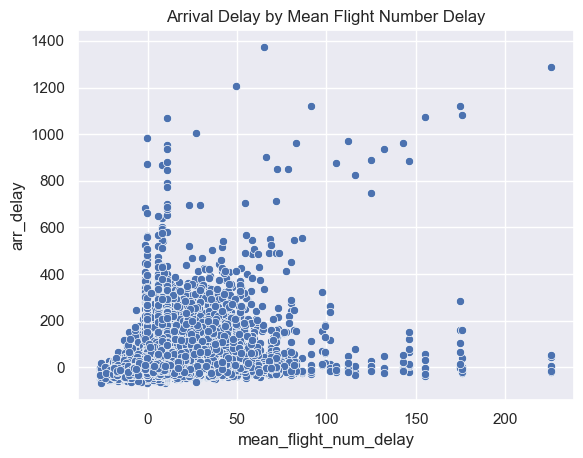

In [28]:
g = sns.scatterplot(data=df_flights_train, x='mean_flight_num_delay', y='arr_delay')
g.set_title('Arrival Delay by Mean Flight Number Delay')

In [29]:
df_flights_train['mean_flight_num_delay'].corr(df_flights_train['arr_delay'])

0.2715570310921278

In [ ]:
len(df_flights_train[df_flights_train['mean_flight_num_delay']==df_flights_train['arr_delay']])

In [ ]:
unique_flights = (df_flights_train['op_unique_carrier'] + df_flights_train['op_carrier_fl_num'].astype(str) + df_flights_train['crs_dep_time_of_day'].astype(str)+df_flights_train['origin_city_name']+df_flights_train['dest_city_name']).nunique()
unique_flights

In [ ]:
one_flight_only = sum((df_flights_train['op_unique_carrier'] + df_flights_train['op_carrier_fl_num'].astype(str) + df_flights_train['crs_dep_time_of_day'].astype(str)+df_flights_train['origin_city_name']+df_flights_train['dest_city_name']).value_counts()==1)
one_flight_only

In [ ]:
percent_one_flight_only = 100*(one_flight_only/unique_flights)
percent_one_flight_only

In [30]:
df_flights_train = df_flights_train[['mean_flight_num_delay','arr_delay']]

In [56]:
df_flights_train = df_flights_train.dropna()
df_flights_train.head()

,mean_flight_num_delay,arr_delay
0,-5.533333,-14.0
1,-1.500000,-11.0
2,6.066726,-5.0
3,7.961089,-11.0
4,15.913043,-6.0


In [57]:
df_flights_train.isnull().sum()

mean_flight_num_delay    0
arr_delay                0
dtype: int64

In [31]:
df_flights_train.head()

,mean_flight_num_delay,arr_delay
0,-5.533333,-14.0
1,-1.500000,-11.0
2,6.066726,-5.0
3,7.961089,-11.0
4,15.913043,-6.0


In [58]:
# make a pickle of the feature engineered training data
import pickle

fe_flight_num_TRAINING = df_flights_train

with open(r'..\data\fe_flight_num_TRAINING.pickle','wb') as flight_data_file:
     pickle.dump(fe_flight_num_TRAINING, flight_data_file)

## Add Feature to Test Set

In [33]:
df_flights_test = pd.concat([X_test, y_test], axis=1)

In [34]:
df_flights_test['crs_dep_time'] = pd.to_datetime(df_flights_test['crs_dep_time'], format = '%H%M', errors = 'coerce')

In [35]:
df_flights_test[df_flights_test['crs_dep_time'].isnull()]['crs_dep_time']

62334   NaT
9472    NaT
91457   NaT
46870   NaT
64893   NaT
Name: crs_dep_time, dtype: datetime64[ns]

In [36]:
df_flights_test = df_flights_test[(df_flights_test['crs_dep_time'].isnull()==False)]

In [37]:
df_flights_test['crs_dep_time_hour'] = df_flights_test['crs_dep_time'].dt.hour

In [38]:
cut_labels_5 = ['early morning', 'late morning', 'midday', 'late afternoon', 'evening']
cut_bins = [1, 5, 10, 15, 20, 24]
df_flights_test['crs_dep_time_of_day'] = pd.cut(df_flights_test['crs_dep_time_hour'], bins=cut_bins, labels=cut_labels_5)

In [ ]:
# # build dict1: carrier+fl_num+TOD+origin+dest

# filter_df = df_flights_train[['op_unique_carrier','op_carrier_fl_num','crs_dep_time_of_day','origin_city_name','dest_city_name','arr_delay']]
# mean_arr_delay_1 = filter_df.groupby(['op_unique_carrier','op_carrier_fl_num','crs_dep_time_of_day','origin_city_name','dest_city_name'],observed=True).agg(mean_arr_delay=('arr_delay', 'mean'), samples=('arr_delay', 'count'))

# # drop all elements in dict1 that don't have at least 5 samples

# mean_arr_delay_1 = mean_arr_delay_1[mean_arr_delay_1['samples']>5]
# mean_arr_delay_1 = mean_arr_delay_1.reset_index()
# mean_arr_delay_1.head()

# # build dict

# mean_arr_delay_1['key'] = mean_arr_delay_1['op_unique_carrier']+mean_arr_delay_1['op_carrier_fl_num'].astype(str)+mean_arr_delay_1['crs_dep_time_of_day'].astype(str)+mean_arr_delay_1['origin_city_name']+mean_arr_delay_1['dest_city_name']
# mean_arr_delay_1 = mean_arr_delay_1[['key','mean_arr_delay']]
# mean_arr_delay_1.set_index('key',inplace=True)
# mean_arr_delay_1 = mean_arr_delay_1.T
# dict1 = mean_arr_delay_1.to_dict('records')
# dict1

In [ ]:
# # build dict2: TOD+origin+dest

# filter_df = df_flights_train[['crs_dep_time_of_day','origin_city_name','dest_city_name','arr_delay']]
# mean_arr_delay_2 = filter_df.groupby(['crs_dep_time_of_day','origin_city_name','dest_city_name'],observed=True).agg(mean_arr_delay=('arr_delay', 'mean'), samples=('arr_delay', 'count'))

# # drop all elements in dict2 that don't have at least 5 samples

# mean_arr_delay_2 = mean_arr_delay_2[mean_arr_delay_2['samples']>5]
# mean_arr_delay_2 = mean_arr_delay_2.reset_index()
# mean_arr_delay_2.head()

# # build dict2

# mean_arr_delay_2['key'] = mean_arr_delay_2['crs_dep_time_of_day'].astype(str)+mean_arr_delay_2['origin_city_name']+mean_arr_delay_2['dest_city_name']
# mean_arr_delay_2 = mean_arr_delay_2[['key','mean_arr_delay']]
# mean_arr_delay_2.set_index('key',inplace=True)
# mean_arr_delay_2 = mean_arr_delay_2.T
# dict2 = mean_arr_delay_2.to_dict('records')
# dict2

In [ ]:
# # build dict3: TOD

# filter_df = df_flights_train[['crs_dep_time_of_day','arr_delay']]
# mean_arr_delay_3 = filter_df.groupby(['crs_dep_time_of_day'],observed=True).agg(mean_arr_delay=('arr_delay', 'mean'), samples=('arr_delay', 'count'))

# # drop all elements in dict3 that don't have at least 5 samples

# mean_arr_delay_3 = mean_arr_delay_3[mean_arr_delay_3['samples']>5]
# mean_arr_delay_3 = mean_arr_delay_3.reset_index()
# mean_arr_delay_3.head()

# # build dict3

# mean_arr_delay_3['key'] = mean_arr_delay_3['crs_dep_time_of_day'].astype(str)
# mean_arr_delay_3 = mean_arr_delay_3[['key','mean_arr_delay']]
# mean_arr_delay_3.set_index('key',inplace=True)
# mean_arr_delay_3 = mean_arr_delay_3.T
# dict3 = mean_arr_delay_3.to_dict('records')
# dict3


In [39]:
df_flights_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,arr_delay,crs_dep_time_hour,crs_dep_time_of_day
88483,2019-04-11,AA,AA,AA,1315,AA,N932NN,1315,11298,DFW,...,0,N,263,266.0,225.0,1,1660,2.0,16,late afternoon
83174,2019-05-02,AA,AA_CODESHARE,AA,5289,OH,N253PS,5289,11278,DCA,...,0,N,73,72.0,57.0,1,234,69.0,22,evening
79063,2018-07-03,DL,DL,DL,2339,DL,N388DA,2339,14747,SEA,...,0,N,127,122.0,93.0,1,689,-4.0,10,late morning
68760,2018-02-12,WN,WN,WN,1913,WN,N8695D,1913,13198,MCI,...,0,N,90,79.0,69.0,1,491,-13.0,16,late afternoon
92929,2019-03-09,AA,AA_CODESHARE,AA,4136,MQ,N271NN,4136,11298,DFW,...,0,N,72,84.0,50.0,1,282,48.0,12,midday


In [40]:
df_flights_test = df_flights_test.reset_index(drop=True)
df_flights_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,arr_delay,crs_dep_time_hour,crs_dep_time_of_day
0,2019-04-11,AA,AA,AA,1315,AA,N932NN,1315,11298,DFW,...,0,N,263,266.0,225.0,1,1660,2.0,16,late afternoon
1,2019-05-02,AA,AA_CODESHARE,AA,5289,OH,N253PS,5289,11278,DCA,...,0,N,73,72.0,57.0,1,234,69.0,22,evening
2,2018-07-03,DL,DL,DL,2339,DL,N388DA,2339,14747,SEA,...,0,N,127,122.0,93.0,1,689,-4.0,10,late morning
3,2018-02-12,WN,WN,WN,1913,WN,N8695D,1913,13198,MCI,...,0,N,90,79.0,69.0,1,491,-13.0,16,late afternoon
4,2019-03-09,AA,AA_CODESHARE,AA,4136,MQ,N271NN,4136,11298,DFW,...,0,N,72,84.0,50.0,1,282,48.0,12,midday


In [ ]:
df_flights_test.columns

In [41]:
key1 = df_flights_test['op_unique_carrier'] + df_flights_test['op_carrier_fl_num'].astype(str) + df_flights_test['crs_dep_time_of_day'].astype(str) + df_flights_test['origin_city_name'] + df_flights_test['dest_city_name']
key2 = df_flights_test['crs_dep_time_of_day'].astype(str)+ df_flights_test['origin_city_name']+ df_flights_test['dest_city_name']
key3 = df_flights_test['crs_dep_time_of_day'].astype(str)

df_flights_test['key1'] = key1
df_flights_test['key2'] = key2
df_flights_test['key3'] = key3

for ind in df_flights_test.index:

    if df_flights_test['key1'][ind] in dict1[0]:
            
        df_flights_test['mean_flight_num_delay'] = df_flights_test['key1'].map(dict1[0])

    elif df_flights_test['key2'][ind] in dict2[0]:

        df_flights_test['mean_flight_num_delay'] = df_flights_test['key2'].map(dict2[0])

    else:

        df_flights_test['mean_flight_num_delay'] = df_flights_test['key3'].map(dict3[0])

In [42]:
df_flights_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,air_time,flights,distance,arr_delay,crs_dep_time_hour,crs_dep_time_of_day,key1,key2,key3,mean_flight_num_delay
0,2019-04-11,AA,AA,AA,1315,AA,N932NN,1315,11298,DFW,...,225.0,1,1660,2.0,16,late afternoon,"AA1315late afternoonDallas/Fort Worth, TXSeatt...","late afternoonDallas/Fort Worth, TXSeattle, WA",late afternoon,16.857143
1,2019-05-02,AA,AA_CODESHARE,AA,5289,OH,N253PS,5289,11278,DCA,...,57.0,1,234,69.0,22,evening,"OH5289eveningWashington, DCWhite Plains, NY","eveningWashington, DCWhite Plains, NY",evening,NaN
2,2018-07-03,DL,DL,DL,2339,DL,N388DA,2339,14747,SEA,...,93.0,1,689,-4.0,10,late morning,"DL2339late morningSeattle, WASalt Lake City, UT","late morningSeattle, WASalt Lake City, UT",late morning,-6.272727
3,2018-02-12,WN,WN,WN,1913,WN,N8695D,1913,13198,MCI,...,69.0,1,491,-13.0,16,late afternoon,"WN1913late afternoonKansas City, MONashville, TN","late afternoonKansas City, MONashville, TN",late afternoon,NaN
4,2019-03-09,AA,AA_CODESHARE,AA,4136,MQ,N271NN,4136,11298,DFW,...,50.0,1,282,48.0,12,midday,"MQ4136middayDallas/Fort Worth, TXLubbock, TX","middayDallas/Fort Worth, TXLubbock, TX",midday,NaN


In [43]:
df_flights_test = df_flights_test.replace({'mean_flight_num_delay' : {np.nan: df_flights_test['key3'].map(dict3[0])}})

In [44]:
df_flights_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,air_time,flights,distance,arr_delay,crs_dep_time_hour,crs_dep_time_of_day,key1,key2,key3,mean_flight_num_delay
0,2019-04-11,AA,AA,AA,1315,AA,N932NN,1315,11298,DFW,...,225.0,1,1660,2.0,16,late afternoon,"AA1315late afternoonDallas/Fort Worth, TXSeatt...","late afternoonDallas/Fort Worth, TXSeattle, WA",late afternoon,16.857143
1,2019-05-02,AA,AA_CODESHARE,AA,5289,OH,N253PS,5289,11278,DCA,...,57.0,1,234,69.0,22,evening,"OH5289eveningWashington, DCWhite Plains, NY","eveningWashington, DCWhite Plains, NY",evening,7.961089
2,2018-07-03,DL,DL,DL,2339,DL,N388DA,2339,14747,SEA,...,93.0,1,689,-4.0,10,late morning,"DL2339late morningSeattle, WASalt Lake City, UT","late morningSeattle, WASalt Lake City, UT",late morning,-6.272727
3,2018-02-12,WN,WN,WN,1913,WN,N8695D,1913,13198,MCI,...,69.0,1,491,-13.0,16,late afternoon,"WN1913late afternoonKansas City, MONashville, TN","late afternoonKansas City, MONashville, TN",late afternoon,10.821680
4,2019-03-09,AA,AA_CODESHARE,AA,4136,MQ,N271NN,4136,11298,DFW,...,50.0,1,282,48.0,12,midday,"MQ4136middayDallas/Fort Worth, TXLubbock, TX","middayDallas/Fort Worth, TXLubbock, TX",midday,6.066726


In [ ]:
df_flights_test['key1'][2]

In [ ]:
df_flights_test['key1'][ind] in dict1[0]

In [ ]:
df_flights_test['key2'][ind] in dict2[0]

In [ ]:
df_flights_test[['op_unique_carrier','op_carrier_fl_num','crs_dep_time_of_day','origin_city_name','dest_city_name','arr_delay']].head()

In [ ]:
# target_rel(df_flights_train, feature='mean_flight_num_delay', feature_title='Mean Flight Number Delay')

Text(0.5, 1.0, 'Arrival Delay by Mean Flight Number Delay - TEST SET')

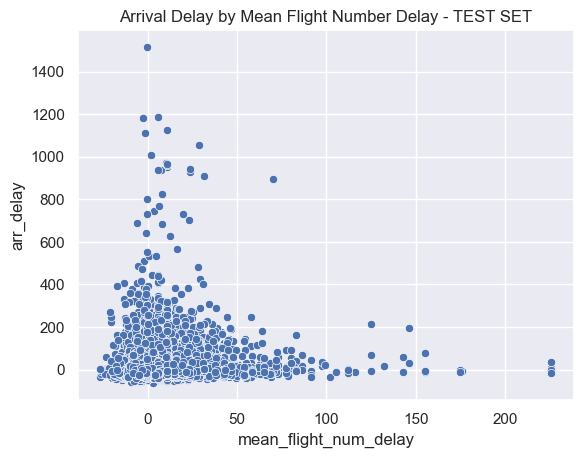

In [45]:
g = sns.scatterplot(data=df_flights_test, x='mean_flight_num_delay', y='arr_delay')
g.set_title('Arrival Delay by Mean Flight Number Delay - TEST SET')

In [46]:
df_flights_test['mean_flight_num_delay'].corr(df_flights_test['arr_delay'])

0.06742058734315398

In [ ]:
len(df_flights_train[df_flights_train['mean_flight_num_delay']==df_flights_train['arr_delay']])

In [ ]:
unique_flights = (df_flights_train['op_unique_carrier'] + df_flights_train['op_carrier_fl_num'] + df_flights_train['crs_dep_time_of_day']).nunique()
unique_flights

In [ ]:
one_flight_only = sum((df_flights_train['op_unique_carrier'] + df_flights_train['op_carrier_fl_num'] + df_flights_train['crs_dep_time_of_day']).value_counts()==1)
one_flight_only

In [ ]:
percent_one_flight_only = 100*(one_flight_only/unique_flights)
percent_one_flight_only

In [47]:
df_flights_test = df_flights_test[['mean_flight_num_delay','arr_delay']]

In [48]:
df_flights_test.head()

,mean_flight_num_delay,arr_delay
0,16.857143,2.0
1,7.961089,69.0
2,-6.272727,-4.0
3,10.821680,-13.0
4,6.066726,48.0


In [54]:
df_flights_test = df_flights_test.dropna()
df_flights_test.head()

,mean_flight_num_delay,arr_delay
0,16.857143,2.0
1,7.961089,69.0
2,-6.272727,-4.0
3,10.821680,-13.0
4,6.066726,48.0


In [55]:
# make a pickle of the feature engineered test data
import pickle

fe_flight_num_TEST = df_flights_test

with open(r'..\data\fe_flight_num_TEST.pickle','wb') as flight_data_file:
     pickle.dump(fe_flight_num_TEST, flight_data_file)

# Round 6

In [38]:
# get the cleaned dataset

import pickle

with open(r'..\data\flight_data.pickle','rb') as flight_data_file:
     df_flights = pickle.load(flight_data_file)

In [39]:
X = df_flights.drop(columns='arr_delay')
y = df_flights['arr_delay']

In [40]:
X.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'cancelled', 'diverted', 'dup',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance'],
      dtype='object')

In [41]:
X.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,crs_arr_time,arr_time,cancelled,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance
0,2018-01-01,WN,WN,WN,5431,WN,N291WN,5431,12889,LAS,...,2350,9.0,0,0,N,140,124.0,112.0,1,986
1,2018-01-01,WN,WN,WN,989,WN,N287WN,989,12889,LAS,...,155,241.0,0,0,N,150,161.0,142.0,1,1099
2,2018-01-01,WN,WN,WN,1664,WN,N751SW,1664,12889,LAS,...,1120,1111.0,0,0,N,150,145.0,132.0,1,1099
3,2018-01-01,WN,WN,WN,1106,WN,N704SW,1106,12889,LAS,...,830,827.0,0,0,N,55,50.0,34.0,1,197
4,2018-01-01,WN,WN,WN,1559,WN,N423WN,1559,12889,LAS,...,1835,1912.0,0,0,N,55,51.0,34.0,1,197


In [42]:
y.head()

0    19.0
1    46.0
2    -9.0
3    -3.0
4    37.0
Name: arr_delay, dtype: float64

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [44]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(74267, 31)
(24756, 31)
(74267,)
(24756,)


## Add Features to Training Set

In [45]:
df_flights_train = pd.concat([X_train, y_train], axis=1)

In [46]:
df_flights_train = df_flights_train.reset_index(drop=True)
df_flights_train.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,arr_time,cancelled,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,arr_delay
0,2018-02-02,WN,WN,WN,182,WN,N8557Q,182,10397,ATL,...,1031.0,0,0,N,125,108.0,91.0,1,666,-14.0
1,2019-07-30,DL,DL_CODESHARE,DL,4247,OO,N460SW,4247,14869,SLC,...,1754.0,0,0,N,60,50.0,30.0,1,175,-11.0
2,2018-04-30,DL,DL_CODESHARE,DL,4701,OO,N878AS,4701,12278,ICT,...,1417.0,0,0,N,112,98.0,81.0,1,545,-5.0
3,2019-04-15,AA,AA_CODESHARE,AA,4966,PT,N620AE,4966,14100,PHL,...,2222.0,0,0,N,47,41.0,17.0,1,55,-11.0
4,2019-09-12,WN,WN,WN,4292,WN,N7719A,4292,11292,DEN,...,1959.0,0,0,N,120,102.0,87.0,1,602,-6.0


### Departure TOD, Mean Arrival Delay by Flight/Route/TOD

In [47]:
df_flights_train['crs_dep_time'] = pd.to_datetime(df_flights_train['crs_dep_time'], format = '%H%M', errors = 'coerce')

In [48]:
df_flights_train[df_flights_train['crs_dep_time'].isnull()]['crs_dep_time']

4895    NaT
10588   NaT
12314   NaT
18881   NaT
22268   NaT
26293   NaT
38058   NaT
40328   NaT
44936   NaT
56819   NaT
71654   NaT
73900   NaT
Name: crs_dep_time, dtype: datetime64[ns]

In [49]:
df_flights_train = df_flights_train[(df_flights_train['crs_dep_time'].isnull()==False)]

In [50]:
df_flights_train['crs_dep_time_hour'] = df_flights_train['crs_dep_time'].dt.hour

In [51]:
cut_labels_5 = ['early morning', 'late morning', 'midday', 'late afternoon', 'evening']
cut_bins = [0, 5, 10, 15, 20, 24]
df_flights_train['crs_dep_time_of_day'] = pd.cut(df_flights_train['crs_dep_time_hour'], bins=cut_bins, labels=cut_labels_5)

In [54]:
# build dict1: carrier+fl_num+TOD+origin+dest

filter_df = df_flights_train[['op_unique_carrier','op_carrier_fl_num','crs_dep_time_of_day','origin_city_name','dest_city_name','arr_delay']]
mean_arr_delay_1 = filter_df.groupby(['op_unique_carrier','op_carrier_fl_num','crs_dep_time_of_day','origin_city_name','dest_city_name'],observed=True).agg(mean_arr_delay=('arr_delay', 'mean'), samples=('arr_delay', 'count'))

# drop all elements in dict1 that don't have at least 5 samples

mean_arr_delay_1 = mean_arr_delay_1[mean_arr_delay_1['samples']>5]
mean_arr_delay_1 = mean_arr_delay_1.reset_index()
mean_arr_delay_1.head()

# build dict

mean_arr_delay_1['key'] = mean_arr_delay_1['op_unique_carrier']+mean_arr_delay_1['op_carrier_fl_num'].astype(str)+mean_arr_delay_1['crs_dep_time_of_day'].astype(str)+mean_arr_delay_1['origin_city_name']+mean_arr_delay_1['dest_city_name']
mean_arr_delay_1 = mean_arr_delay_1[['key','mean_arr_delay']]
mean_arr_delay_1.set_index('key',inplace=True)
mean_arr_delay_1 = mean_arr_delay_1.T
dict1 = mean_arr_delay_1.to_dict('records')
dict1

[{'9E5027late morningCincinnati, OHDetroit, MI': -10.833333333333334,
  'AA31late morningLos Angeles, CAHonolulu, HI': -14.666666666666666,
  'AA34late morningDallas/Fort Worth, TXNewark, NJ': 16.0,
  'AA34middayNewark, NJDallas/Fort Worth, TX': -1.1666666666666667,
  'AA58middayKona, HILos Angeles, CA': -12.833333333333334,
  'AA163late morningLos Angeles, CAWashington, DC': -4.571428571428571,
  'AA163late afternoonWashington, DCLos Angeles, CA': -9.5,
  'AA164late morningSan Francisco, CANew York, NY': -0.3333333333333333,
  'AA168middayLas Vegas, NVChicago, IL': 4.0,
  'AA201late morningSanta Ana, CAPhoenix, AZ': -13.0,
  'AA205middayLos Angeles, CAKahului, HI': 38.5,
  'AA243middayNew York, NYMiami, FL': -9.666666666666666,
  'AA254middayKahului, HILos Angeles, CA': -10.166666666666666,
  'AA315middayDallas/Fort Worth, TXDetroit, MI': 17.0,
  'AA315late afternoonDetroit, MIDallas/Fort Worth, TX': 11.857142857142858,
  'AA395late morningChicago, ILSan Juan, PR': -11.0,
  'AA407midd

In [55]:
# build dict2: TOD+origin+dest

filter_df = df_flights_train[['crs_dep_time_of_day','origin_city_name','dest_city_name','arr_delay']]
mean_arr_delay_2 = filter_df.groupby(['crs_dep_time_of_day','origin_city_name','dest_city_name'],observed=True).agg(mean_arr_delay=('arr_delay', 'mean'), samples=('arr_delay', 'count'))

# drop all elements in dict2 that don't have at least 5 samples

mean_arr_delay_2 = mean_arr_delay_2[mean_arr_delay_2['samples']>5]
mean_arr_delay_2 = mean_arr_delay_2.reset_index()
mean_arr_delay_2.head()

# build dict2

mean_arr_delay_2['key'] = mean_arr_delay_2['crs_dep_time_of_day'].astype(str)+mean_arr_delay_2['origin_city_name']+mean_arr_delay_2['dest_city_name']
mean_arr_delay_2 = mean_arr_delay_2[['key','mean_arr_delay']]
mean_arr_delay_2.set_index('key',inplace=True)
mean_arr_delay_2 = mean_arr_delay_2.T
dict2 = mean_arr_delay_2.to_dict('records')
dict2

[{'early morningAnchorage, AKSeattle, WA': -9.166666666666666,
  'early morningAustin, TXDallas/Fort Worth, TX': -9.714285714285714,
  'early morningBoston, MAChicago, IL': -0.42857142857142855,
  'early morningBoston, MAMiami, FL': -9.666666666666666,
  'early morningCedar Rapids/Iowa City, IAAtlanta, GA': -3.1666666666666665,
  'early morningChicago, ILDenver, CO': -19.666666666666668,
  'early morningChicago, ILFort Lauderdale, FL': -15.0,
  'early morningChicago, ILMiami, FL': 2.2222222222222223,
  'early morningColumbus, OHCharlotte, NC': -3.3333333333333335,
  'early morningDenver, CODallas/Fort Worth, TX': -12.0,
  'early morningEugene, ORSeattle, WA': -9.666666666666666,
  'early morningGreensboro/High Point, NCCharlotte, NC': -4.0,
  'early morningHouston, TXDallas/Fort Worth, TX': -11.444444444444445,
  'early morningIndianapolis, INPhiladelphia, PA': -7.857142857142857,
  'early morningKilleen, TXDallas/Fort Worth, TX': -5.166666666666667,
  'early morningLos Angeles, CAChic

In [56]:
# build dict3: TOD

filter_df = df_flights_train[['crs_dep_time_of_day','arr_delay']]
mean_arr_delay_3 = filter_df.groupby(['crs_dep_time_of_day'],observed=True).agg(mean_arr_delay=('arr_delay', 'mean'), samples=('arr_delay', 'count'))
mean_arr_delay_3 = mean_arr_delay_3.reset_index()

# build dict3

mean_arr_delay_3['key'] = mean_arr_delay_3['crs_dep_time_of_day'].astype(str)
mean_arr_delay_3 = mean_arr_delay_3[['key','mean_arr_delay']]
mean_arr_delay_3.set_index('key',inplace=True)
mean_arr_delay_3 = mean_arr_delay_3.T
dict3 = mean_arr_delay_3.to_dict('records')
dict3



[{'early morning': -1.5143617021276596,
  'late morning': -0.21252833298990315,
  'midday': 6.066725820763088,
  'late afternoon': 10.821680164853596,
  'evening': 7.96108866680842}]

In [58]:
df_flights_train.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,arr_delay,crs_dep_time_hour,crs_dep_time_of_day
0,2018-02-02,WN,WN,WN,182,WN,N8557Q,182,10397,ATL,...,0,N,125,108.0,91.0,1,666,-14.0,8,late morning
1,2019-07-30,DL,DL_CODESHARE,DL,4247,OO,N460SW,4247,14869,SLC,...,0,N,60,50.0,30.0,1,175,-11.0,17,late afternoon
2,2018-04-30,DL,DL_CODESHARE,DL,4701,OO,N878AS,4701,12278,ICT,...,0,N,112,98.0,81.0,1,545,-5.0,12,midday
3,2019-04-15,AA,AA_CODESHARE,AA,4966,PT,N620AE,4966,14100,PHL,...,0,N,47,41.0,17.0,1,55,-11.0,21,evening
4,2019-09-12,WN,WN,WN,4292,WN,N7719A,4292,11292,DEN,...,0,N,120,102.0,87.0,1,602,-6.0,19,late afternoon


In [59]:
key1 = df_flights_train['op_unique_carrier'] + df_flights_train['op_carrier_fl_num'].astype(str) + df_flights_train['crs_dep_time_of_day'].astype(str) + df_flights_train['origin_city_name'] + df_flights_train['dest_city_name']
key2 = df_flights_train['crs_dep_time_of_day'].astype(str)+ df_flights_train['origin_city_name']+ df_flights_train['dest_city_name']
key3 = df_flights_train['crs_dep_time_of_day'].astype(str)

df_flights_train['key1'] = key1
df_flights_train['key2'] = key2
df_flights_train['key3'] = key3

for ind in df_flights_train.index:

    if df_flights_train['key1'][ind] in dict1[0]:
            
        df_flights_train['mean_flight_num_delay'] = df_flights_train['key1'].map(dict1[0])

    elif df_flights_train['key2'][ind] in dict2[0]:

        df_flights_train['mean_flight_num_delay'] = df_flights_train['key2'].map(dict2[0])

    else:

        df_flights_train['mean_flight_num_delay'] = df_flights_train['key3'].map(dict3[0])

In [60]:
df_flights_train.head(10)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,air_time,flights,distance,arr_delay,crs_dep_time_hour,crs_dep_time_of_day,key1,key2,key3,mean_flight_num_delay
0,2018-02-02,WN,WN,WN,182,WN,N8557Q,182,10397,ATL,...,91.0,1,666,-14.0,8,late morning,"WN182late morningAtlanta, GAPhiladelphia, PA","late morningAtlanta, GAPhiladelphia, PA",late morning,-5.533333
1,2019-07-30,DL,DL_CODESHARE,DL,4247,OO,N460SW,4247,14869,SLC,...,30.0,1,175,-11.0,17,late afternoon,"OO4247late afternoonSalt Lake City, UTTwin Fal...","late afternoonSalt Lake City, UTTwin Falls, ID",late afternoon,-1.500000
2,2018-04-30,DL,DL_CODESHARE,DL,4701,OO,N878AS,4701,12278,ICT,...,81.0,1,545,-5.0,12,midday,"OO4701middayWichita, KSMinneapolis, MN","middayWichita, KSMinneapolis, MN",midday,NaN
3,2019-04-15,AA,AA_CODESHARE,AA,4966,PT,N620AE,4966,14100,PHL,...,17.0,1,55,-11.0,21,evening,"PT4966eveningPhiladelphia, PAAllentown/Bethleh...","eveningPhiladelphia, PAAllentown/Bethlehem/Eas...",evening,NaN
4,2019-09-12,WN,WN,WN,4292,WN,N7719A,4292,11292,DEN,...,87.0,1,602,-6.0,19,late afternoon,"WN4292late afternoonDenver, COPhoenix, AZ","late afternoonDenver, COPhoenix, AZ",late afternoon,15.913043
5,2019-06-13,WN,WN,WN,3941,WN,N215WN,3941,10994,CHS,...,62.0,1,472,-20.0,14,midday,"WN3941middayCharleston, SCBaltimore, MD","middayCharleston, SCBaltimore, MD",midday,7.000000
6,2019-09-12,WN,WN,WN,682,WN,N783SW,682,11292,DEN,...,116.0,1,853,-20.0,11,midday,"WN682middayDenver, COSan Diego, CA","middayDenver, COSan Diego, CA",midday,6.714286
7,2019-03-06,AA,AA,AA,1391,AA,N191AN,1391,15024,STT,...,153.0,1,1107,28.0,16,late afternoon,"AA1391late afternoonCharlotte Amalie, VIMiami, FL","late afternoonCharlotte Amalie, VIMiami, FL",late afternoon,NaN
8,2019-08-06,AA,AA_CODESHARE,AA,3376,MQ,N663AR,3376,13930,ORD,...,43.0,1,264,25.0,15,midday,"MQ3376middayChicago, ILCincinnati, OH","middayChicago, ILCincinnati, OH",midday,16.333333
9,2019-03-06,UA,UA,UA,351,UA,N595UA,351,10721,BOS,...,391.0,1,2704,138.0,15,midday,"UA351middayBoston, MASan Francisco, CA","middayBoston, MASan Francisco, CA",midday,3.100000


In [61]:
df_flights_train = df_flights_train.replace({'mean_flight_num_delay' : {np.nan: df_flights_train['key3'].map(dict3[0])}})

In [62]:
df_flights_train.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,air_time,flights,distance,arr_delay,crs_dep_time_hour,crs_dep_time_of_day,key1,key2,key3,mean_flight_num_delay
0,2018-02-02,WN,WN,WN,182,WN,N8557Q,182,10397,ATL,...,91.0,1,666,-14.0,8,late morning,"WN182late morningAtlanta, GAPhiladelphia, PA","late morningAtlanta, GAPhiladelphia, PA",late morning,-5.533333
1,2019-07-30,DL,DL_CODESHARE,DL,4247,OO,N460SW,4247,14869,SLC,...,30.0,1,175,-11.0,17,late afternoon,"OO4247late afternoonSalt Lake City, UTTwin Fal...","late afternoonSalt Lake City, UTTwin Falls, ID",late afternoon,-1.500000
2,2018-04-30,DL,DL_CODESHARE,DL,4701,OO,N878AS,4701,12278,ICT,...,81.0,1,545,-5.0,12,midday,"OO4701middayWichita, KSMinneapolis, MN","middayWichita, KSMinneapolis, MN",midday,6.066726
3,2019-04-15,AA,AA_CODESHARE,AA,4966,PT,N620AE,4966,14100,PHL,...,17.0,1,55,-11.0,21,evening,"PT4966eveningPhiladelphia, PAAllentown/Bethleh...","eveningPhiladelphia, PAAllentown/Bethlehem/Eas...",evening,7.961089
4,2019-09-12,WN,WN,WN,4292,WN,N7719A,4292,11292,DEN,...,87.0,1,602,-6.0,19,late afternoon,"WN4292late afternoonDenver, COPhoenix, AZ","late afternoonDenver, COPhoenix, AZ",late afternoon,15.913043


Text(0.5, 1.0, 'Arrival Delay by Mean Flight Number Delay - TRAINING SET')

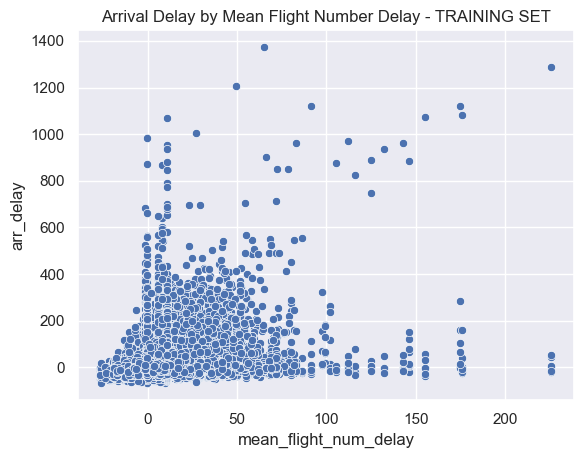

In [64]:
g = sns.scatterplot(data=df_flights_train, x='mean_flight_num_delay', y='arr_delay')
g.set_title('Arrival Delay by Mean Flight Number Delay - TRAINING SET')

In [65]:
df_flights_train['mean_flight_num_delay'].corr(df_flights_train['arr_delay'])

0.2715666211408335

### Mean Monthly Arrival Delay

In [66]:
df_flights_train['fl_date'] = pd.to_datetime(df_flights_train['fl_date'])
df_flights_train['year'] = df_flights_train['fl_date'].dt.year
df_flights_train['month'] = df_flights_train['fl_date'].dt.month
df_flights_train['day'] = df_flights_train['fl_date'].dt.day

In [67]:
mean_month_arr_delay = df_flights_train.groupby('month', as_index=False).agg(mean_month_arr_delay = ('arr_delay','mean')).sort_values(by='mean_month_arr_delay', ascending=False)
mean_month_arr_delay.set_index('month',inplace=True)
mean_month_arr_delay = mean_month_arr_delay.T
mean_month_arr_delay

month,6,8,7,5,2,12,4,3,11,10,1,9
mean_month_arr_delay,10.172922,9.901052,8.82538,7.071467,6.057037,5.955058,5.175516,3.088488,2.61433,2.033773,1.904884,0.13061


In [68]:
month_dict = mean_month_arr_delay.to_dict('records')

In [69]:
month_dict

[{6: 10.172921836228287,
  8: 9.90105169604503,
  7: 8.825379609544468,
  5: 7.07146695325094,
  2: 6.057037037037037,
  12: 5.955057989690721,
  4: 5.1755157253973625,
  3: 3.0884877182598403,
  11: 2.614330218068536,
  10: 2.0337734111145225,
  1: 1.9048838797814207,
  9: 0.13061018658598084}]

In [70]:
df_flights_train['mean_month_arr_delay'] = df_flights_train['month'].map(month_dict[0])

In [71]:
df_flights_train.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,crs_dep_time_hour,crs_dep_time_of_day,key1,key2,key3,mean_flight_num_delay,year,month,day,mean_month_arr_delay
0,2018-02-02,WN,WN,WN,182,WN,N8557Q,182,10397,ATL,...,8,late morning,"WN182late morningAtlanta, GAPhiladelphia, PA","late morningAtlanta, GAPhiladelphia, PA",late morning,-5.533333,2018,2,2,6.057037
1,2019-07-30,DL,DL_CODESHARE,DL,4247,OO,N460SW,4247,14869,SLC,...,17,late afternoon,"OO4247late afternoonSalt Lake City, UTTwin Fal...","late afternoonSalt Lake City, UTTwin Falls, ID",late afternoon,-1.500000,2019,7,30,8.825380
2,2018-04-30,DL,DL_CODESHARE,DL,4701,OO,N878AS,4701,12278,ICT,...,12,midday,"OO4701middayWichita, KSMinneapolis, MN","middayWichita, KSMinneapolis, MN",midday,6.066726,2018,4,30,5.175516
3,2019-04-15,AA,AA_CODESHARE,AA,4966,PT,N620AE,4966,14100,PHL,...,21,evening,"PT4966eveningPhiladelphia, PAAllentown/Bethleh...","eveningPhiladelphia, PAAllentown/Bethlehem/Eas...",evening,7.961089,2019,4,15,5.175516
4,2019-09-12,WN,WN,WN,4292,WN,N7719A,4292,11292,DEN,...,19,late afternoon,"WN4292late afternoonDenver, COPhoenix, AZ","late afternoonDenver, COPhoenix, AZ",late afternoon,15.913043,2019,9,12,0.130610


### Season

In [89]:
season_dict = {
    1:'Winter',
    2:'Winter',
    3:'Spring',
    4:'Spring',
    5:'Spring',
    6:'Summer',
    7:'Summer',
    8:'Summer',
    9:'Fall',
    10:'Fall',
    11:'Fall',
    12:'Winter'}
df_flights_train["season"] = df_flights_train["month"].map(season_dict)


In [90]:
df_flights_train.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,crs_dep_time_of_day,key1,key2,key3,mean_flight_num_delay,year,month,day,mean_month_arr_delay,season
0,2018-02-02,WN,WN,WN,182,WN,N8557Q,182,10397,ATL,...,late morning,"WN182late morningAtlanta, GAPhiladelphia, PA","late morningAtlanta, GAPhiladelphia, PA",late morning,-5.533333,2018,2,2,6.057037,Winter
1,2019-07-30,DL,DL_CODESHARE,DL,4247,OO,N460SW,4247,14869,SLC,...,late afternoon,"OO4247late afternoonSalt Lake City, UTTwin Fal...","late afternoonSalt Lake City, UTTwin Falls, ID",late afternoon,-1.500000,2019,7,30,8.825380,Summer
2,2018-04-30,DL,DL_CODESHARE,DL,4701,OO,N878AS,4701,12278,ICT,...,midday,"OO4701middayWichita, KSMinneapolis, MN","middayWichita, KSMinneapolis, MN",midday,6.066726,2018,4,30,5.175516,Spring
3,2019-04-15,AA,AA_CODESHARE,AA,4966,PT,N620AE,4966,14100,PHL,...,evening,"PT4966eveningPhiladelphia, PAAllentown/Bethleh...","eveningPhiladelphia, PAAllentown/Bethlehem/Eas...",evening,7.961089,2019,4,15,5.175516,Spring
4,2019-09-12,WN,WN,WN,4292,WN,N7719A,4292,11292,DEN,...,late afternoon,"WN4292late afternoonDenver, COPhoenix, AZ","late afternoonDenver, COPhoenix, AZ",late afternoon,15.913043,2019,9,12,0.130610,Fall


### Day of Week

In [93]:
df_flights_train['day_of_week'] = df_flights_train['fl_date'].dt.day_name()

In [94]:
df_flights_train.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,key1,key2,key3,mean_flight_num_delay,year,month,day,mean_month_arr_delay,season,day_of_week
0,2018-02-02,WN,WN,WN,182,WN,N8557Q,182,10397,ATL,...,"WN182late morningAtlanta, GAPhiladelphia, PA","late morningAtlanta, GAPhiladelphia, PA",late morning,-5.533333,2018,2,2,6.057037,Winter,Friday
1,2019-07-30,DL,DL_CODESHARE,DL,4247,OO,N460SW,4247,14869,SLC,...,"OO4247late afternoonSalt Lake City, UTTwin Fal...","late afternoonSalt Lake City, UTTwin Falls, ID",late afternoon,-1.500000,2019,7,30,8.825380,Summer,Tuesday
2,2018-04-30,DL,DL_CODESHARE,DL,4701,OO,N878AS,4701,12278,ICT,...,"OO4701middayWichita, KSMinneapolis, MN","middayWichita, KSMinneapolis, MN",midday,6.066726,2018,4,30,5.175516,Spring,Monday
3,2019-04-15,AA,AA_CODESHARE,AA,4966,PT,N620AE,4966,14100,PHL,...,"PT4966eveningPhiladelphia, PAAllentown/Bethleh...","eveningPhiladelphia, PAAllentown/Bethlehem/Eas...",evening,7.961089,2019,4,15,5.175516,Spring,Monday
4,2019-09-12,WN,WN,WN,4292,WN,N7719A,4292,11292,DEN,...,"WN4292late afternoonDenver, COPhoenix, AZ","late afternoonDenver, COPhoenix, AZ",late afternoon,15.913043,2019,9,12,0.130610,Fall,Thursday


### Weekday/Weekend and Arr_Delay

In [98]:
df_flights_train["is_weekend"] = df_flights_train['fl_date'].dt.dayofweek > 4

In [100]:
df_flights_train.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,key2,key3,mean_flight_num_delay,year,month,day,mean_month_arr_delay,season,day_of_week,is_weekend
0,2018-02-02,WN,WN,WN,182,WN,N8557Q,182,10397,ATL,...,"late morningAtlanta, GAPhiladelphia, PA",late morning,-5.533333,2018,2,2,6.057037,Winter,Friday,False
1,2019-07-30,DL,DL_CODESHARE,DL,4247,OO,N460SW,4247,14869,SLC,...,"late afternoonSalt Lake City, UTTwin Falls, ID",late afternoon,-1.500000,2019,7,30,8.825380,Summer,Tuesday,False
2,2018-04-30,DL,DL_CODESHARE,DL,4701,OO,N878AS,4701,12278,ICT,...,"middayWichita, KSMinneapolis, MN",midday,6.066726,2018,4,30,5.175516,Spring,Monday,False
3,2019-04-15,AA,AA_CODESHARE,AA,4966,PT,N620AE,4966,14100,PHL,...,"eveningPhiladelphia, PAAllentown/Bethlehem/Eas...",evening,7.961089,2019,4,15,5.175516,Spring,Monday,False
4,2019-09-12,WN,WN,WN,4292,WN,N7719A,4292,11292,DEN,...,"late afternoonDenver, COPhoenix, AZ",late afternoon,15.913043,2019,9,12,0.130610,Fall,Thursday,False


### Holidays and Arr_Delay

In [101]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dr = pd.date_range(start='2018-01-01', end='2019-12-31')

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

df_flights_train['is_holiday'] = df_flights_train['fl_date'].isin(holidays)
df_flights_train.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,key3,mean_flight_num_delay,year,month,day,mean_month_arr_delay,season,day_of_week,is_weekend,is_holiday
0,2018-02-02,WN,WN,WN,182,WN,N8557Q,182,10397,ATL,...,late morning,-5.533333,2018,2,2,6.057037,Winter,Friday,False,False
1,2019-07-30,DL,DL_CODESHARE,DL,4247,OO,N460SW,4247,14869,SLC,...,late afternoon,-1.500000,2019,7,30,8.825380,Summer,Tuesday,False,False
2,2018-04-30,DL,DL_CODESHARE,DL,4701,OO,N878AS,4701,12278,ICT,...,midday,6.066726,2018,4,30,5.175516,Spring,Monday,False,False
3,2019-04-15,AA,AA_CODESHARE,AA,4966,PT,N620AE,4966,14100,PHL,...,evening,7.961089,2019,4,15,5.175516,Spring,Monday,False,False
4,2019-09-12,WN,WN,WN,4292,WN,N7719A,4292,11292,DEN,...,late afternoon,15.913043,2019,9,12,0.130610,Fall,Thursday,False,False


### Region and Arr_Delay

In [104]:
new_origin = df_flights_train['origin_city_name'].str.split(",", n = 1, expand = True)
new_origin.head()

,0,1
0,Atlanta,GA
1,Salt Lake City,UT
2,Wichita,KS
3,Philadelphia,PA
4,Denver,CO


In [105]:
new_dest = df_flights_train['dest_city_name'].str.split(",", n = 1, expand = True)
new_dest.head()

,0,1
0,Philadelphia,PA
1,Twin Falls,ID
2,Minneapolis,MN
3,Allentown/Bethlehem/Easton,PA
4,Phoenix,AZ


In [106]:
df_flights_train['origin_state'] = new_origin[1].str.strip()
df_flights_train['dest_state'] = new_dest[1].str.strip()
df_flights_train.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,year,month,day,mean_month_arr_delay,season,day_of_week,is_weekend,is_holiday,origin_state,dest_state
0,2018-02-02,WN,WN,WN,182,WN,N8557Q,182,10397,ATL,...,2018,2,2,6.057037,Winter,Friday,False,False,GA,PA
1,2019-07-30,DL,DL_CODESHARE,DL,4247,OO,N460SW,4247,14869,SLC,...,2019,7,30,8.825380,Summer,Tuesday,False,False,UT,ID
2,2018-04-30,DL,DL_CODESHARE,DL,4701,OO,N878AS,4701,12278,ICT,...,2018,4,30,5.175516,Spring,Monday,False,False,KS,MN
3,2019-04-15,AA,AA_CODESHARE,AA,4966,PT,N620AE,4966,14100,PHL,...,2019,4,15,5.175516,Spring,Monday,False,False,PA,PA
4,2019-09-12,WN,WN,WN,4292,WN,N7719A,4292,11292,DEN,...,2019,9,12,0.130610,Fall,Thursday,False,False,CO,AZ


In [107]:
# Add a region feature that groups states into four regions
# Region Dictionary for States *includes DC and Puerto Rico

state_region = {
    'WA': 'West',
    'OR': 'West',
    'CA': 'West',
    'AK': 'West',
    'HI': 'West',
    'ID': 'West',
    'MT': 'West',
    'WY': 'West',
    'NV': 'West',
    'UT': 'West',
    'CO': 'West',
    'AZ': 'West',
    'NM': 'West',
    'ND': 'Midwest',
    'SD': 'Midwest',
    'MN': 'Midwest',
    'NE': 'Midwest',
    'KS': 'Midwest',
    'IA': 'Midwest',
    'MO': 'Midwest',
    'WI': 'Midwest',
    'IL': 'Midwest',
    'MI': 'Midwest',
    'IN': 'Midwest',
    'OH': 'Midwest',
    'VT': 'Northeast',
    'ME': 'Northeast',
    'NH': 'Northeast',
    'MA': 'Northeast',
    'NY': 'Northeast',
    'PA': 'Northeast',
    'RI': 'Northeast',
    'CT': 'Northeast',
    'NJ': 'Northeast',
    'DE': 'South',
    'MD': 'South',
    'WV': 'South',
    'DC': 'South',
    'VA': 'South',
    'KY': 'South',
    'NC': 'South',
    'OK': 'South',
    'TX': 'South',
    'AR': 'South',
    'LA': 'South',
    'MS': 'South',
    'AL': 'South',
    'TN': 'South',
    'SC': 'South',
    'GA': 'South',
    'FL': 'South',
    'PR': 'Other',
    'VI': 'Other',
    'TT': 'Other'
}
len(state_region)

54

In [108]:
df_flights_train["origin_region"] = df_flights_train["origin_state"].map(state_region)

In [109]:
df_flights_train["dest_region"] = df_flights_train["dest_state"].map(state_region)

In [110]:
df_flights_train.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,day,mean_month_arr_delay,season,day_of_week,is_weekend,is_holiday,origin_state,dest_state,origin_region,dest_region
0,2018-02-02,WN,WN,WN,182,WN,N8557Q,182,10397,ATL,...,2,6.057037,Winter,Friday,False,False,GA,PA,South,Northeast
1,2019-07-30,DL,DL_CODESHARE,DL,4247,OO,N460SW,4247,14869,SLC,...,30,8.825380,Summer,Tuesday,False,False,UT,ID,West,West
2,2018-04-30,DL,DL_CODESHARE,DL,4701,OO,N878AS,4701,12278,ICT,...,30,5.175516,Spring,Monday,False,False,KS,MN,Midwest,Midwest
3,2019-04-15,AA,AA_CODESHARE,AA,4966,PT,N620AE,4966,14100,PHL,...,15,5.175516,Spring,Monday,False,False,PA,PA,Northeast,Northeast
4,2019-09-12,WN,WN,WN,4292,WN,N7719A,4292,11292,DEN,...,12,0.130610,Fall,Thursday,False,False,CO,AZ,West,West


### Make a pickle of the feature engineered training set

In [152]:
df_flights_train.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'cancelled', 'diverted', 'dup',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'arr_delay', 'crs_dep_time_hour', 'crs_dep_time_of_day',
       'key1', 'key2', 'key3', 'mean_flight_num_delay', 'year', 'month', 'day',
       'mean_month_arr_delay', 'season', 'day_of_week', 'is_weekend',
       'is_holiday', 'origin_state', 'dest_state', 'origin_region',
       'dest_region'],
      dtype='object')

In [ ]:
df_flights_train = df_flights_train[['crs_dep_time_of_day',
       'mean_flight_num_delay', 'mean_month_arr_delay', 'season', 'day_of_week', 'is_weekend',
       'is_holiday', 'origin_region',
       'dest_region']]

In [ ]:
# make a pickle of the feature engineered training data
import pickle

fe_flight_num_TRAINING = df_flights_train

with open(r'..\data\fe_flight_num_TRAINING.pickle','wb') as flight_data_file:
     pickle.dump(fe_flight_num_TRAINING, flight_data_file)

## Add Features to Test Set

In [121]:
df_flights_test = pd.concat([X_test, y_test], axis=1)

### Departure TOD, Mean Arrival Delay by Flight/Route/TOD

In [122]:
df_flights_test['crs_dep_time'] = pd.to_datetime(df_flights_test['crs_dep_time'], format = '%H%M', errors = 'coerce')

In [123]:
df_flights_test[df_flights_test['crs_dep_time'].isnull()]['crs_dep_time']

62334   NaT
9472    NaT
91457   NaT
46870   NaT
64893   NaT
Name: crs_dep_time, dtype: datetime64[ns]

In [124]:
df_flights_test = df_flights_test[(df_flights_test['crs_dep_time'].isnull()==False)]

In [125]:
df_flights_test['crs_dep_time_hour'] = df_flights_test['crs_dep_time'].dt.hour

In [126]:
cut_labels_5 = ['early morning', 'late morning', 'midday', 'late afternoon', 'evening']
cut_bins = [0, 5, 10, 15, 20, 24]
df_flights_test['crs_dep_time_of_day'] = pd.cut(df_flights_test['crs_dep_time_hour'], bins=cut_bins, labels=cut_labels_5)

In [127]:
df_flights_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,arr_delay,crs_dep_time_hour,crs_dep_time_of_day
88483,2019-04-11,AA,AA,AA,1315,AA,N932NN,1315,11298,DFW,...,0,N,263,266.0,225.0,1,1660,2.0,16,late afternoon
83174,2019-05-02,AA,AA_CODESHARE,AA,5289,OH,N253PS,5289,11278,DCA,...,0,N,73,72.0,57.0,1,234,69.0,22,evening
79063,2018-07-03,DL,DL,DL,2339,DL,N388DA,2339,14747,SEA,...,0,N,127,122.0,93.0,1,689,-4.0,10,late morning
68760,2018-02-12,WN,WN,WN,1913,WN,N8695D,1913,13198,MCI,...,0,N,90,79.0,69.0,1,491,-13.0,16,late afternoon
92929,2019-03-09,AA,AA_CODESHARE,AA,4136,MQ,N271NN,4136,11298,DFW,...,0,N,72,84.0,50.0,1,282,48.0,12,midday


In [128]:
df_flights_test = df_flights_test.reset_index(drop=True)
df_flights_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,arr_delay,crs_dep_time_hour,crs_dep_time_of_day
0,2019-04-11,AA,AA,AA,1315,AA,N932NN,1315,11298,DFW,...,0,N,263,266.0,225.0,1,1660,2.0,16,late afternoon
1,2019-05-02,AA,AA_CODESHARE,AA,5289,OH,N253PS,5289,11278,DCA,...,0,N,73,72.0,57.0,1,234,69.0,22,evening
2,2018-07-03,DL,DL,DL,2339,DL,N388DA,2339,14747,SEA,...,0,N,127,122.0,93.0,1,689,-4.0,10,late morning
3,2018-02-12,WN,WN,WN,1913,WN,N8695D,1913,13198,MCI,...,0,N,90,79.0,69.0,1,491,-13.0,16,late afternoon
4,2019-03-09,AA,AA_CODESHARE,AA,4136,MQ,N271NN,4136,11298,DFW,...,0,N,72,84.0,50.0,1,282,48.0,12,midday


In [129]:
key1 = df_flights_test['op_unique_carrier'] + df_flights_test['op_carrier_fl_num'].astype(str) + df_flights_test['crs_dep_time_of_day'].astype(str) + df_flights_test['origin_city_name'] + df_flights_test['dest_city_name']
key2 = df_flights_test['crs_dep_time_of_day'].astype(str)+ df_flights_test['origin_city_name']+ df_flights_test['dest_city_name']
key3 = df_flights_test['crs_dep_time_of_day'].astype(str)

df_flights_test['key1'] = key1
df_flights_test['key2'] = key2
df_flights_test['key3'] = key3

for ind in df_flights_test.index:

    if df_flights_test['key1'][ind] in dict1[0]:
            
        df_flights_test['mean_flight_num_delay'] = df_flights_test['key1'].map(dict1[0])

    elif df_flights_test['key2'][ind] in dict2[0]:

        df_flights_test['mean_flight_num_delay'] = df_flights_test['key2'].map(dict2[0])

    else:

        df_flights_test['mean_flight_num_delay'] = df_flights_test['key3'].map(dict3[0])

In [130]:
df_flights_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,air_time,flights,distance,arr_delay,crs_dep_time_hour,crs_dep_time_of_day,key1,key2,key3,mean_flight_num_delay
0,2019-04-11,AA,AA,AA,1315,AA,N932NN,1315,11298,DFW,...,225.0,1,1660,2.0,16,late afternoon,"AA1315late afternoonDallas/Fort Worth, TXSeatt...","late afternoonDallas/Fort Worth, TXSeattle, WA",late afternoon,16.857143
1,2019-05-02,AA,AA_CODESHARE,AA,5289,OH,N253PS,5289,11278,DCA,...,57.0,1,234,69.0,22,evening,"OH5289eveningWashington, DCWhite Plains, NY","eveningWashington, DCWhite Plains, NY",evening,NaN
2,2018-07-03,DL,DL,DL,2339,DL,N388DA,2339,14747,SEA,...,93.0,1,689,-4.0,10,late morning,"DL2339late morningSeattle, WASalt Lake City, UT","late morningSeattle, WASalt Lake City, UT",late morning,-6.272727
3,2018-02-12,WN,WN,WN,1913,WN,N8695D,1913,13198,MCI,...,69.0,1,491,-13.0,16,late afternoon,"WN1913late afternoonKansas City, MONashville, TN","late afternoonKansas City, MONashville, TN",late afternoon,NaN
4,2019-03-09,AA,AA_CODESHARE,AA,4136,MQ,N271NN,4136,11298,DFW,...,50.0,1,282,48.0,12,midday,"MQ4136middayDallas/Fort Worth, TXLubbock, TX","middayDallas/Fort Worth, TXLubbock, TX",midday,NaN


In [131]:
df_flights_test = df_flights_test.replace({'mean_flight_num_delay' : {np.nan: df_flights_test['key3'].map(dict3[0])}})

In [132]:
df_flights_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,air_time,flights,distance,arr_delay,crs_dep_time_hour,crs_dep_time_of_day,key1,key2,key3,mean_flight_num_delay
0,2019-04-11,AA,AA,AA,1315,AA,N932NN,1315,11298,DFW,...,225.0,1,1660,2.0,16,late afternoon,"AA1315late afternoonDallas/Fort Worth, TXSeatt...","late afternoonDallas/Fort Worth, TXSeattle, WA",late afternoon,16.857143
1,2019-05-02,AA,AA_CODESHARE,AA,5289,OH,N253PS,5289,11278,DCA,...,57.0,1,234,69.0,22,evening,"OH5289eveningWashington, DCWhite Plains, NY","eveningWashington, DCWhite Plains, NY",evening,7.961089
2,2018-07-03,DL,DL,DL,2339,DL,N388DA,2339,14747,SEA,...,93.0,1,689,-4.0,10,late morning,"DL2339late morningSeattle, WASalt Lake City, UT","late morningSeattle, WASalt Lake City, UT",late morning,-6.272727
3,2018-02-12,WN,WN,WN,1913,WN,N8695D,1913,13198,MCI,...,69.0,1,491,-13.0,16,late afternoon,"WN1913late afternoonKansas City, MONashville, TN","late afternoonKansas City, MONashville, TN",late afternoon,10.821680
4,2019-03-09,AA,AA_CODESHARE,AA,4136,MQ,N271NN,4136,11298,DFW,...,50.0,1,282,48.0,12,midday,"MQ4136middayDallas/Fort Worth, TXLubbock, TX","middayDallas/Fort Worth, TXLubbock, TX",midday,6.066726


Text(0.5, 1.0, 'Arrival Delay by Mean Flight Number Delay - TEST SET')

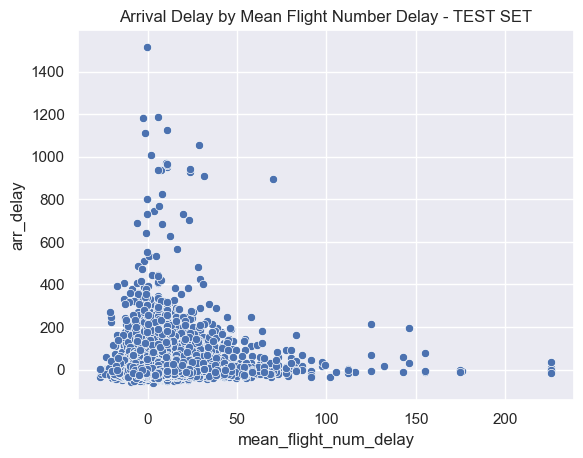

In [133]:
g = sns.scatterplot(data=df_flights_test, x='mean_flight_num_delay', y='arr_delay')
g.set_title('Arrival Delay by Mean Flight Number Delay - TEST SET')

In [134]:
df_flights_test['mean_flight_num_delay'].corr(df_flights_test['arr_delay'])

0.06743948194308284

### Mean Monthly Arrival Delay

In [135]:
df_flights_test['fl_date'] = pd.to_datetime(df_flights_test['fl_date'])
df_flights_test['year'] = df_flights_test['fl_date'].dt.year
df_flights_test['month'] = df_flights_test['fl_date'].dt.month
df_flights_test['day'] = df_flights_test['fl_date'].dt.day

In [136]:
df_flights_test['mean_month_arr_delay'] = df_flights_test['month'].map(month_dict[0])

In [137]:
df_flights_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,crs_dep_time_hour,crs_dep_time_of_day,key1,key2,key3,mean_flight_num_delay,year,month,day,mean_month_arr_delay
0,2019-04-11,AA,AA,AA,1315,AA,N932NN,1315,11298,DFW,...,16,late afternoon,"AA1315late afternoonDallas/Fort Worth, TXSeatt...","late afternoonDallas/Fort Worth, TXSeattle, WA",late afternoon,16.857143,2019,4,11,5.175516
1,2019-05-02,AA,AA_CODESHARE,AA,5289,OH,N253PS,5289,11278,DCA,...,22,evening,"OH5289eveningWashington, DCWhite Plains, NY","eveningWashington, DCWhite Plains, NY",evening,7.961089,2019,5,2,7.071467
2,2018-07-03,DL,DL,DL,2339,DL,N388DA,2339,14747,SEA,...,10,late morning,"DL2339late morningSeattle, WASalt Lake City, UT","late morningSeattle, WASalt Lake City, UT",late morning,-6.272727,2018,7,3,8.825380
3,2018-02-12,WN,WN,WN,1913,WN,N8695D,1913,13198,MCI,...,16,late afternoon,"WN1913late afternoonKansas City, MONashville, TN","late afternoonKansas City, MONashville, TN",late afternoon,10.821680,2018,2,12,6.057037
4,2019-03-09,AA,AA_CODESHARE,AA,4136,MQ,N271NN,4136,11298,DFW,...,12,midday,"MQ4136middayDallas/Fort Worth, TXLubbock, TX","middayDallas/Fort Worth, TXLubbock, TX",midday,6.066726,2019,3,9,3.088488


### Season

In [138]:
df_flights_test["season"] = df_flights_test["month"].map(season_dict)

In [139]:
df_flights_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,crs_dep_time_of_day,key1,key2,key3,mean_flight_num_delay,year,month,day,mean_month_arr_delay,season
0,2019-04-11,AA,AA,AA,1315,AA,N932NN,1315,11298,DFW,...,late afternoon,"AA1315late afternoonDallas/Fort Worth, TXSeatt...","late afternoonDallas/Fort Worth, TXSeattle, WA",late afternoon,16.857143,2019,4,11,5.175516,Spring
1,2019-05-02,AA,AA_CODESHARE,AA,5289,OH,N253PS,5289,11278,DCA,...,evening,"OH5289eveningWashington, DCWhite Plains, NY","eveningWashington, DCWhite Plains, NY",evening,7.961089,2019,5,2,7.071467,Spring
2,2018-07-03,DL,DL,DL,2339,DL,N388DA,2339,14747,SEA,...,late morning,"DL2339late morningSeattle, WASalt Lake City, UT","late morningSeattle, WASalt Lake City, UT",late morning,-6.272727,2018,7,3,8.825380,Summer
3,2018-02-12,WN,WN,WN,1913,WN,N8695D,1913,13198,MCI,...,late afternoon,"WN1913late afternoonKansas City, MONashville, TN","late afternoonKansas City, MONashville, TN",late afternoon,10.821680,2018,2,12,6.057037,Winter
4,2019-03-09,AA,AA_CODESHARE,AA,4136,MQ,N271NN,4136,11298,DFW,...,midday,"MQ4136middayDallas/Fort Worth, TXLubbock, TX","middayDallas/Fort Worth, TXLubbock, TX",midday,6.066726,2019,3,9,3.088488,Spring


### Day of Week

In [140]:
df_flights_test['day_of_week'] = df_flights_test['fl_date'].dt.day_name()

In [141]:
df_flights_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,key1,key2,key3,mean_flight_num_delay,year,month,day,mean_month_arr_delay,season,day_of_week
0,2019-04-11,AA,AA,AA,1315,AA,N932NN,1315,11298,DFW,...,"AA1315late afternoonDallas/Fort Worth, TXSeatt...","late afternoonDallas/Fort Worth, TXSeattle, WA",late afternoon,16.857143,2019,4,11,5.175516,Spring,Thursday
1,2019-05-02,AA,AA_CODESHARE,AA,5289,OH,N253PS,5289,11278,DCA,...,"OH5289eveningWashington, DCWhite Plains, NY","eveningWashington, DCWhite Plains, NY",evening,7.961089,2019,5,2,7.071467,Spring,Thursday
2,2018-07-03,DL,DL,DL,2339,DL,N388DA,2339,14747,SEA,...,"DL2339late morningSeattle, WASalt Lake City, UT","late morningSeattle, WASalt Lake City, UT",late morning,-6.272727,2018,7,3,8.825380,Summer,Tuesday
3,2018-02-12,WN,WN,WN,1913,WN,N8695D,1913,13198,MCI,...,"WN1913late afternoonKansas City, MONashville, TN","late afternoonKansas City, MONashville, TN",late afternoon,10.821680,2018,2,12,6.057037,Winter,Monday
4,2019-03-09,AA,AA_CODESHARE,AA,4136,MQ,N271NN,4136,11298,DFW,...,"MQ4136middayDallas/Fort Worth, TXLubbock, TX","middayDallas/Fort Worth, TXLubbock, TX",midday,6.066726,2019,3,9,3.088488,Spring,Saturday


### Weekday/Weekend and Arr_Delay

In [142]:
df_flights_test["is_weekend"] = df_flights_test['fl_date'].dt.dayofweek > 4

In [143]:
df_flights_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,key2,key3,mean_flight_num_delay,year,month,day,mean_month_arr_delay,season,day_of_week,is_weekend
0,2019-04-11,AA,AA,AA,1315,AA,N932NN,1315,11298,DFW,...,"late afternoonDallas/Fort Worth, TXSeattle, WA",late afternoon,16.857143,2019,4,11,5.175516,Spring,Thursday,False
1,2019-05-02,AA,AA_CODESHARE,AA,5289,OH,N253PS,5289,11278,DCA,...,"eveningWashington, DCWhite Plains, NY",evening,7.961089,2019,5,2,7.071467,Spring,Thursday,False
2,2018-07-03,DL,DL,DL,2339,DL,N388DA,2339,14747,SEA,...,"late morningSeattle, WASalt Lake City, UT",late morning,-6.272727,2018,7,3,8.825380,Summer,Tuesday,False
3,2018-02-12,WN,WN,WN,1913,WN,N8695D,1913,13198,MCI,...,"late afternoonKansas City, MONashville, TN",late afternoon,10.821680,2018,2,12,6.057037,Winter,Monday,False
4,2019-03-09,AA,AA_CODESHARE,AA,4136,MQ,N271NN,4136,11298,DFW,...,"middayDallas/Fort Worth, TXLubbock, TX",midday,6.066726,2019,3,9,3.088488,Spring,Saturday,True


### Holidays and Arr_Delay

In [144]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dr = pd.date_range(start='2018-01-01', end='2019-12-31')

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

df_flights_test['is_holiday'] = df_flights_test['fl_date'].isin(holidays)
df_flights_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,key3,mean_flight_num_delay,year,month,day,mean_month_arr_delay,season,day_of_week,is_weekend,is_holiday
0,2019-04-11,AA,AA,AA,1315,AA,N932NN,1315,11298,DFW,...,late afternoon,16.857143,2019,4,11,5.175516,Spring,Thursday,False,False
1,2019-05-02,AA,AA_CODESHARE,AA,5289,OH,N253PS,5289,11278,DCA,...,evening,7.961089,2019,5,2,7.071467,Spring,Thursday,False,False
2,2018-07-03,DL,DL,DL,2339,DL,N388DA,2339,14747,SEA,...,late morning,-6.272727,2018,7,3,8.825380,Summer,Tuesday,False,False
3,2018-02-12,WN,WN,WN,1913,WN,N8695D,1913,13198,MCI,...,late afternoon,10.821680,2018,2,12,6.057037,Winter,Monday,False,False
4,2019-03-09,AA,AA_CODESHARE,AA,4136,MQ,N271NN,4136,11298,DFW,...,midday,6.066726,2019,3,9,3.088488,Spring,Saturday,True,False


### Region and Arr_Delay

In [145]:
new_origin = df_flights_test['origin_city_name'].str.split(",", n = 1, expand = True)
new_origin.head()

,0,1
0,Dallas/Fort Worth,TX
1,Washington,DC
2,Seattle,WA
3,Kansas City,MO
4,Dallas/Fort Worth,TX


In [146]:
new_dest = df_flights_test['dest_city_name'].str.split(",", n = 1, expand = True)
new_dest.head()

,0,1
0,Seattle,WA
1,White Plains,NY
2,Salt Lake City,UT
3,Nashville,TN
4,Lubbock,TX


In [147]:
df_flights_test['origin_state'] = new_origin[1].str.strip()
df_flights_test['dest_state'] = new_dest[1].str.strip()
df_flights_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,year,month,day,mean_month_arr_delay,season,day_of_week,is_weekend,is_holiday,origin_state,dest_state
0,2019-04-11,AA,AA,AA,1315,AA,N932NN,1315,11298,DFW,...,2019,4,11,5.175516,Spring,Thursday,False,False,TX,WA
1,2019-05-02,AA,AA_CODESHARE,AA,5289,OH,N253PS,5289,11278,DCA,...,2019,5,2,7.071467,Spring,Thursday,False,False,DC,NY
2,2018-07-03,DL,DL,DL,2339,DL,N388DA,2339,14747,SEA,...,2018,7,3,8.825380,Summer,Tuesday,False,False,WA,UT
3,2018-02-12,WN,WN,WN,1913,WN,N8695D,1913,13198,MCI,...,2018,2,12,6.057037,Winter,Monday,False,False,MO,TN
4,2019-03-09,AA,AA_CODESHARE,AA,4136,MQ,N271NN,4136,11298,DFW,...,2019,3,9,3.088488,Spring,Saturday,True,False,TX,TX


In [148]:
# Add a region feature that groups states into four regions
# Region Dictionary for States *includes DC and Puerto Rico

state_region = {
    'WA': 'West',
    'OR': 'West',
    'CA': 'West',
    'AK': 'West',
    'HI': 'West',
    'ID': 'West',
    'MT': 'West',
    'WY': 'West',
    'NV': 'West',
    'UT': 'West',
    'CO': 'West',
    'AZ': 'West',
    'NM': 'West',
    'ND': 'Midwest',
    'SD': 'Midwest',
    'MN': 'Midwest',
    'NE': 'Midwest',
    'KS': 'Midwest',
    'IA': 'Midwest',
    'MO': 'Midwest',
    'WI': 'Midwest',
    'IL': 'Midwest',
    'MI': 'Midwest',
    'IN': 'Midwest',
    'OH': 'Midwest',
    'VT': 'Northeast',
    'ME': 'Northeast',
    'NH': 'Northeast',
    'MA': 'Northeast',
    'NY': 'Northeast',
    'PA': 'Northeast',
    'RI': 'Northeast',
    'CT': 'Northeast',
    'NJ': 'Northeast',
    'DE': 'South',
    'MD': 'South',
    'WV': 'South',
    'DC': 'South',
    'VA': 'South',
    'KY': 'South',
    'NC': 'South',
    'OK': 'South',
    'TX': 'South',
    'AR': 'South',
    'LA': 'South',
    'MS': 'South',
    'AL': 'South',
    'TN': 'South',
    'SC': 'South',
    'GA': 'South',
    'FL': 'South',
    'PR': 'Other',
    'VI': 'Other',
    'TT': 'Other'
}
len(state_region)

54

In [149]:
df_flights_test["origin_region"] = df_flights_test["origin_state"].map(state_region)

In [150]:
df_flights_test["dest_region"] = df_flights_test["dest_state"].map(state_region)

In [151]:
df_flights_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,day,mean_month_arr_delay,season,day_of_week,is_weekend,is_holiday,origin_state,dest_state,origin_region,dest_region
0,2019-04-11,AA,AA,AA,1315,AA,N932NN,1315,11298,DFW,...,11,5.175516,Spring,Thursday,False,False,TX,WA,South,West
1,2019-05-02,AA,AA_CODESHARE,AA,5289,OH,N253PS,5289,11278,DCA,...,2,7.071467,Spring,Thursday,False,False,DC,NY,South,Northeast
2,2018-07-03,DL,DL,DL,2339,DL,N388DA,2339,14747,SEA,...,3,8.825380,Summer,Tuesday,False,False,WA,UT,West,West
3,2018-02-12,WN,WN,WN,1913,WN,N8695D,1913,13198,MCI,...,12,6.057037,Winter,Monday,False,False,MO,TN,Midwest,South
4,2019-03-09,AA,AA_CODESHARE,AA,4136,MQ,N271NN,4136,11298,DFW,...,9,3.088488,Spring,Saturday,True,False,TX,TX,South,South


In [ ]:
df_flights_test = df_flights_test[['mean_flight_num_delay','arr_delay']]

In [ ]:
# make a pickle of the feature engineered test data
import pickle

fe_flight_num_TEST = df_flights_test

with open(r'..\data\fe_flight_num_TEST.pickle','wb') as flight_data_file:
     pickle.dump(fe_flight_num_TEST, flight_data_file)